### Search: Solving a Maze Using a Goal-based Agent


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with 

* your implementation,
* documentation including a short discussion of how your implementation works and your design choices, and
* experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. 

Use the provided notebook cells and insert additional code and markdown cells as needed.


## Introduction

The agent has a map of the maze it is in (i.e., the environment is deterministic, discrete, and known). The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  

This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent can just follow the path and does not need percepts. The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree and the goal is to traverse all nodes. We are interested in dynamically creating a search tree with the aim of finding a good/the best path to the goal state. Follow the pseudo code presented in the text book closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible. 

Here is the small example maze:

In [1]:
import pprint
import random
f = open("small_maze.txt", "r")
maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXXXX
X XXX       XX X       X
X XXX  XXXX XX X XXXXX X
X     XXXXX X XXXXXXXX X
XXXXXXX     S  X       X
X    X XXXXXX XX  XXXXXX
X XXXX X          X    X
X        XXX XXX    X  X
XXXXXXXXXX     XXXXXX  X
XG          XX         X
XXXXXXXXXXXXXXXXXXXXXXXX



__Note:__ The mazes above contains cycles and therefore search may not form proper trees unless cycles are prevented. You need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the file [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation.

In [2]:
%run maze_helper.py

maze = parse_maze(maze_str)

# look at two positions in the maze
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)`
print("Position(8,1):", look(maze, (8, 1)))

Position(0,0): X
Position(8,1): X


### Visualize the maze

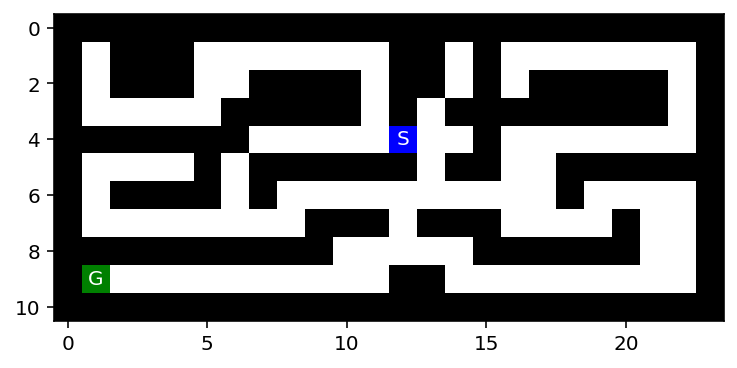

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

show_maze(maze)

## Reset the Mazes
This is code for me to get a new fresh set of mazes when I need it.

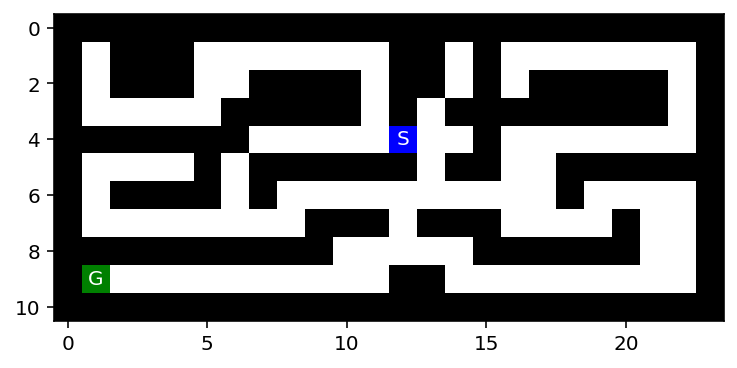

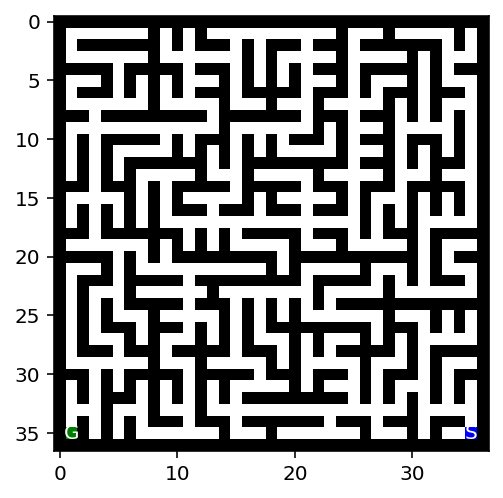

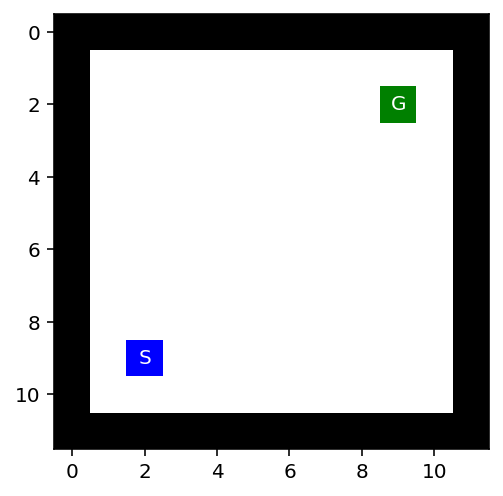

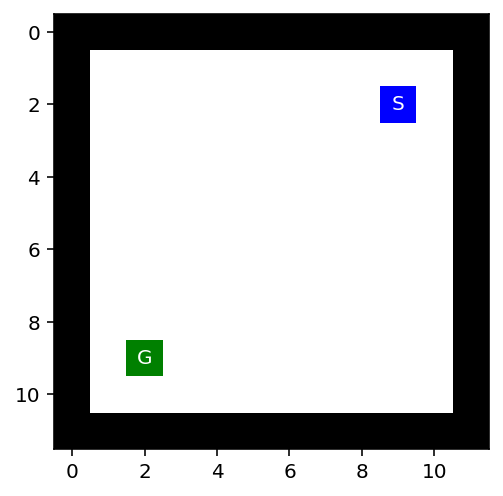

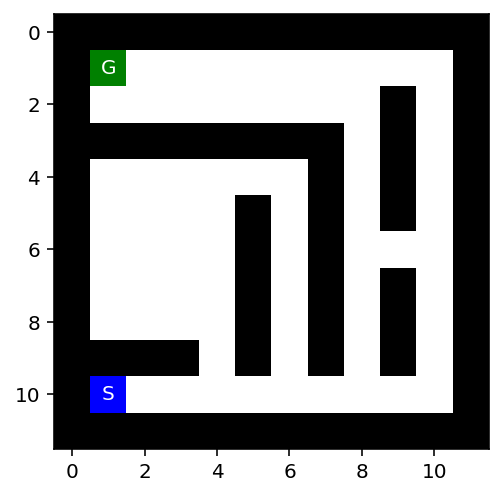

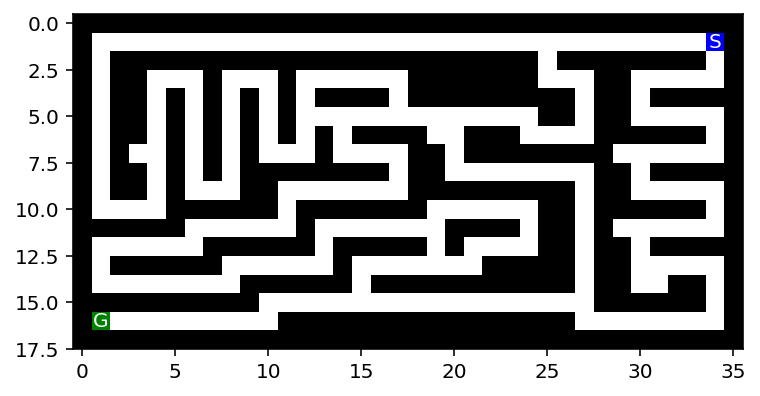

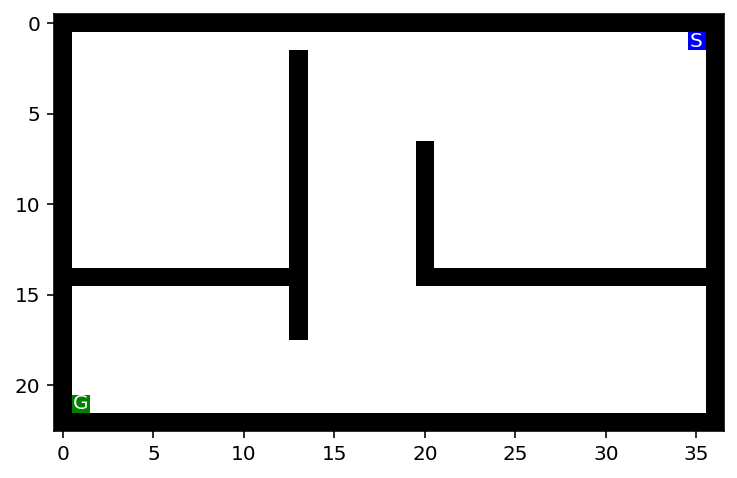

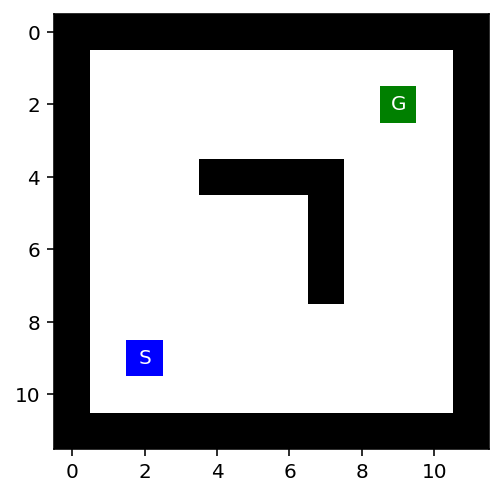

In [4]:
def get_mazes(show = False):
    mazes = {}
    f = open("small_maze.txt", "r")
    small_maze_str = f.read()
    mazes["small_maze"] = parse_maze(small_maze_str)
    if show: show_maze(mazes["small_maze"])
    
    f = open("large_maze.txt", "r")
    large_maze_str = f.read()
    mazes["large_maze"] = parse_maze(large_maze_str)
    if show: show_maze(mazes["large_maze"])

    f = open("empty_maze.txt", "r")
    empty_maze_str = f.read()
    mazes["empty_maze"] = parse_maze(empty_maze_str)
    if show: show_maze(mazes["empty_maze"])

    f = open("empty_2_maze.txt", "r")
    empty_2_maze_str = f.read()
    mazes["empty_2_maze"] = parse_maze(empty_2_maze_str)
    if show: show_maze(mazes["empty_2_maze"])
    
    f = open("loops_maze.txt", "r")
    loops_maze_str = f.read()
    mazes["loops_maze"] = parse_maze(loops_maze_str)
    if show: show_maze(mazes["loops_maze"])
    
    f = open("medium_maze.txt", "r")
    medium_maze_str = f.read()
    mazes["medium_maze"] = parse_maze(medium_maze_str)
    if show: show_maze(mazes["medium_maze"])
    
    f = open("open_maze.txt", "r")
    open_maze_str = f.read()
    mazes["open_maze"] = parse_maze(open_maze_str)
    if show: show_maze(mazes["open_maze"])
    
    f = open("wall_maze.txt", "r")
    wall_maze_str = f.read()
    mazes["wall_maze"] = parse_maze(wall_maze_str)
    if show: show_maze(mazes["wall_maze"])
    
    return mazes

              
get_mazes(show=True)
print()

Find the position of the start and the goal using the helper function `find_pos()`

In [5]:
print("Start location:", find_pos(maze, what = "S"))
print("Goal location:", find_pos(maze, what = "G"))

Start location: (4, 12)
Goal location: (9, 1)


## Tree structure

Implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73):

In [6]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; parent = {repr(self.parent)}; action = {self.action}; cost = {self.cost}"

Example: Create the root node and append the node for going east with a cost of 1.

In [7]:
print("Create root node")
root = Node(pos = (0,0), parent = None, action = None, cost = 0)
print("root:", root)
print("root (reference):", repr(root))

print()
print("Go east with cost 1 (from the parent root)")
node2 = Node(pos = (0,1), parent = root, action = "E", cost = 1)
print("node2:", node2)
print("parent of node2: ", node2.parent)
print("parent of node2 (reference): ", repr(node2.parent))

print()
print("Note that the root note is safe from garbage collection as long as we have a reference in node2") 
root = None
print(root)
print("parent of node2 (reference): ", repr(node2.parent))

print()
print("Once we release node2, the whole tree is deleted.")
node2 = None

Create root node
root: Node - pos = (0, 0); parent = None; action = None; cost = 0
root (reference): <__main__.Node object at 0x00000221F5082E88>

Go east with cost 1 (from the parent root)
node2: Node - pos = (0, 1); parent = <__main__.Node object at 0x00000221F5082E88>; action = E; cost = 1
parent of node2:  Node - pos = (0, 0); parent = None; action = None; cost = 0
parent of node2 (reference):  <__main__.Node object at 0x00000221F5082E88>

Note that the root note is safe from garbage collection as long as we have a reference in node2
None
parent of node2 (reference):  <__main__.Node object at 0x00000221F5082E88>

Once we release node2, the whole tree is deleted.


# Goal
Implement the following search algorithms for solving different mazes:

* Breadth-first search (BFS)
* Depth-first search (DFS)
* Greedy best-first search (GBFS)
* A* search

Run each of the above algorithms on the 
[small maze](small_maze.txt), 
[medium maze](medium_maze.txt), 
[large maze](large_maze.txt), 
[open maze](open_maze.txt),
[wall maze](wall_maze.txt),
[loops maze](loops_maze.txt),
[empty maze](empty_maze.txt), and
[empty 2_maze](empty_2_maze.txt).
For each problem instance and each search algorithm, report the following in a table:

* The solution and its path cost
* Number of nodes expanded
* Maximum tree depth searched
* Maximum size of the frontier.

Display each solution by marking every maze square (or state) visited and the squares on the final path.

## Task 1: Defining the search Problem [1 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

### Initial State
    The (X,Y) coordinate of the 'S' character in the above files.
### Actions
    Moving in 1 square, in any direction where there is not a wall.
### Transition Model
    Answer
### Goal State
    The (X,Y) coordinate where there is a 'G' in the above files.
### Path Cost
    There will be a cost of 1 for each movement in any direction.  There could be an abstraction to group movements through hallways if there is only one direction to go.

## Task 2: Breadth-first and Depth-first [4 points]

Implement these search strategies. Note that the algorithms for BFS and DFS are very different! Make sure that DFS uses less memory by releasing nodes that are not needed anymore. Follow the pseudocode in the textbook.

In [8]:
#psuedo code from page 77 of book
"""
function Breadth-First-Search returns a solution node or failure 
    node <- node(problem.initial)
    if problem.Is-Goal(node.State) then return node
    frontier <- a FIFO queue with node as an element 
    reached <- {problem.INITIAL}
    while not isEmpty(frontier)
        node <- Pop(fontier)
        for each child in Expand(problem, node) do 
            s <- child.State 
            if problem.Is-Goal(s) then return child
            if s is not in reached the 
                add s to reached 
                add child to fontier 
    return failure 

function Expand(problem, node) yeilds nodes 
    s <- node.State
    for each action in problem.Actions(s) 
        s' <- problem.Result(s,actions)
        cost <- node.path-cost + problem.Action-Cost(s,action,s')
        yield Node(State=s', Parent=node, Action - action, Path-Cost=cost)
"""
print()

In [9]:
#Helper functions for the methods below      
def expand(maze, node):
    expanded = []
    #add all the actions to the list
    if maze[node.pos[0]][node.pos[1] + 1] != 'X':
        expanded.append(Node(pos=(node.pos[0],node.pos[1] + 1), parent=node, action='e', cost=node.cost+1))
    if maze[node.pos[0]][node.pos[1] - 1] != 'X':
        expanded.append(Node(pos=(node.pos[0],node.pos[1] - 1), parent=node, action='w', cost=node.cost+1))
    if maze[node.pos[0] - 1][node.pos[1]] != 'X':
        expanded.append(Node(pos=(node.pos[0] - 1,node.pos[1]), parent=node, action='n', cost=node.cost+1))
    if maze[node.pos[0] + 1][node.pos[1]] != 'X':
        expanded.append(Node(pos=(node.pos[0] + 1,node.pos[1]), parent=node, action='s', cost=node.cost+1))
    return expanded
def print_maze(maze):
    for x in maze:
        str = ''
        for y in x:
            str += y
        print(str)
def strListOfNodes(nodes):
    str = ""
    for node in nodes:
        temp = node.__str__()
        str = str + "\t" + temp + "\n"
    return str

def setReached(maze, pos):
    if maze[pos[0]][pos[1]] != 'S' and maze[pos[0]][[1]] != 'G':
        maze[pos[0]][pos[1]] = '.'

def set_path(maze, child):
    node = child.parent
    while node.parent != None:
        if maze[node.pos[0]][node.pos[1]] != 'S' and maze[node.pos[0]][node.pos[1]] != 'G':
            maze[node.pos[0]][node.pos[1]] = 'P'
        node = node.parent
    show_maze(maze)
def paint_DFS(maze, reached, frontier, node):

    for r in reached:
        if maze[r[0]][r[1]] != 'S' and maze[r[0]][r[1]] != 'G':
            maze[r[0]][r[1]] = '.'
    for f in frontier:
        if maze[f.pos[0]][f.pos[1]] != 'S' and maze[f.pos[0]][f.pos[1]] != 'G':
            maze[f.pos[0]][f.pos[1]] = 'F'
    while node.parent != None:
        if maze[node.pos[0]][node.pos[1]] != 'S' and maze[node.pos[0]][node.pos[1]] != 'G':
            maze[node.pos[0]][node.pos[1]] = 'P'
        node = node.parent
    show_maze(maze)

small_maze


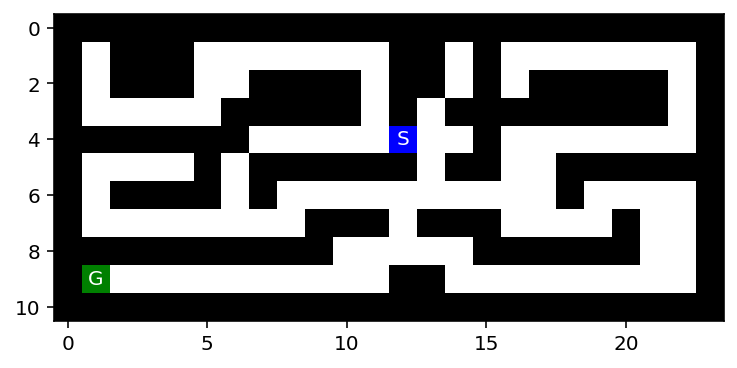

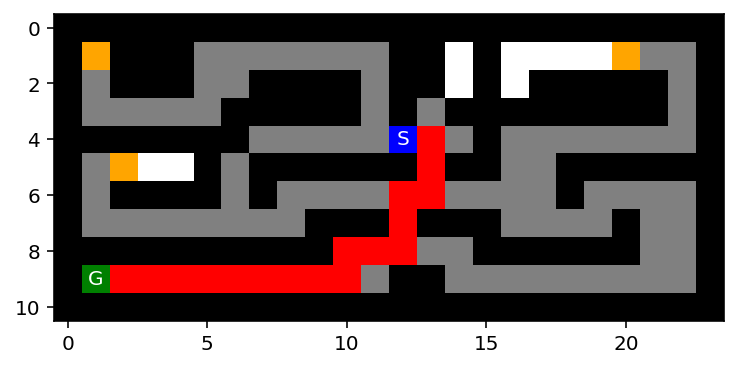

The algorithm took 99 iterations, path_cost 18
large_maze


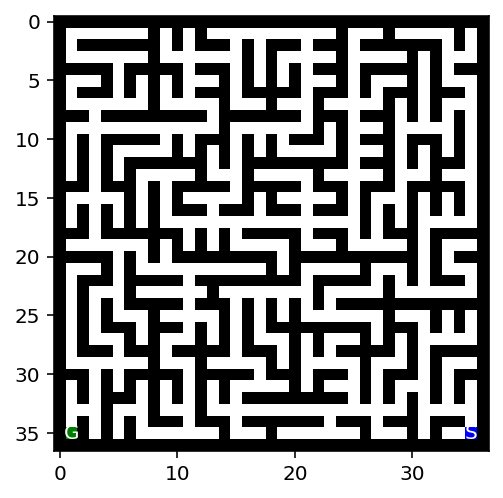

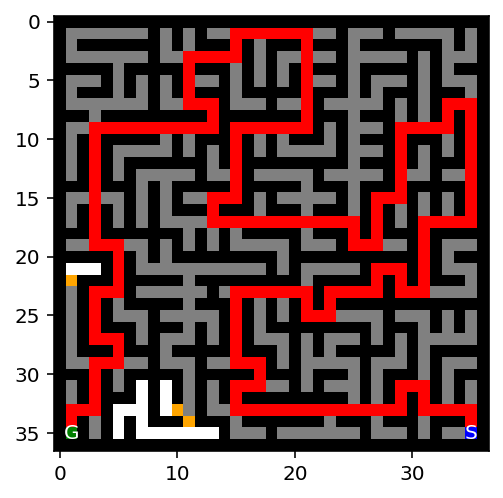

The algorithm took 622 iterations, path_cost 210
empty_maze


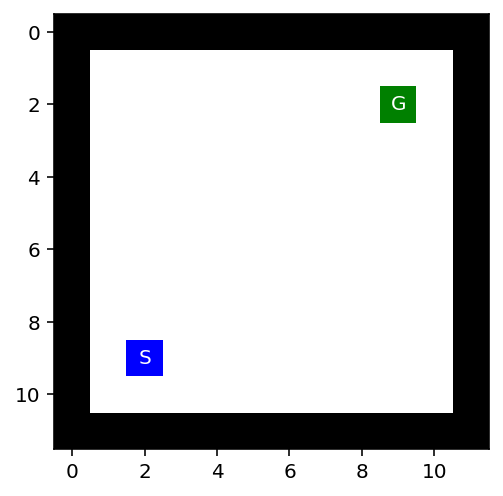

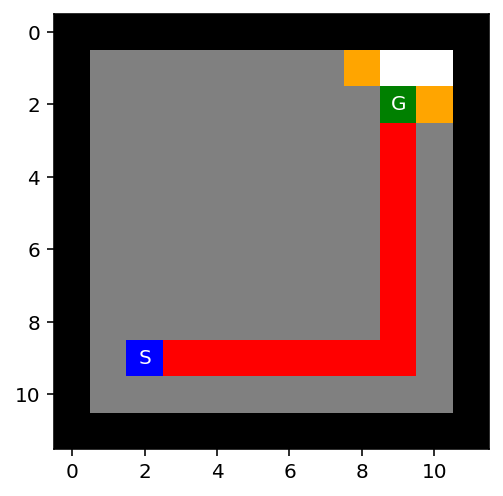

The algorithm took 95 iterations, path_cost 14
empty_2_maze


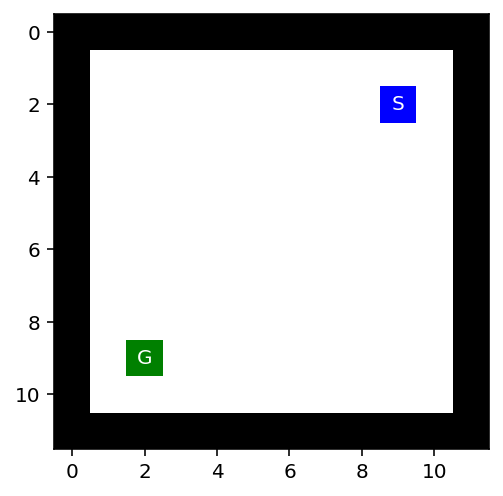

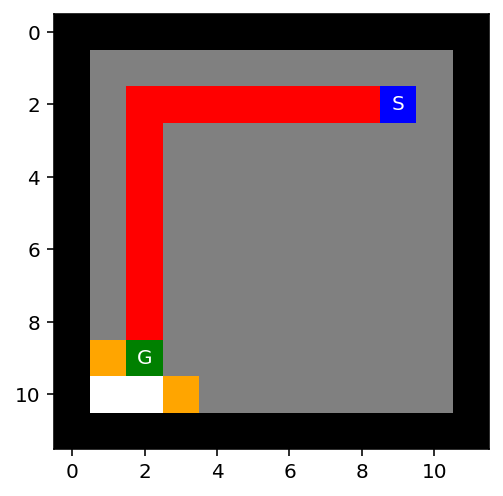

The algorithm took 95 iterations, path_cost 14
loops_maze


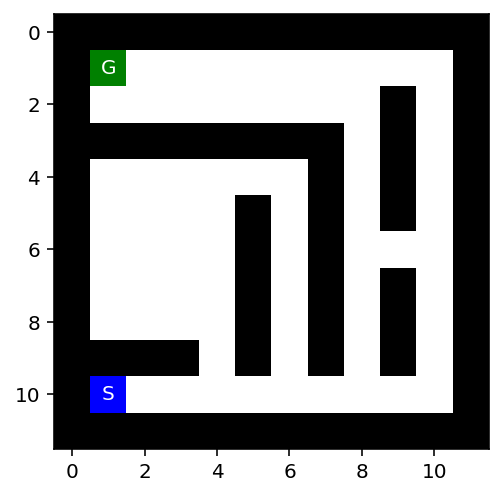

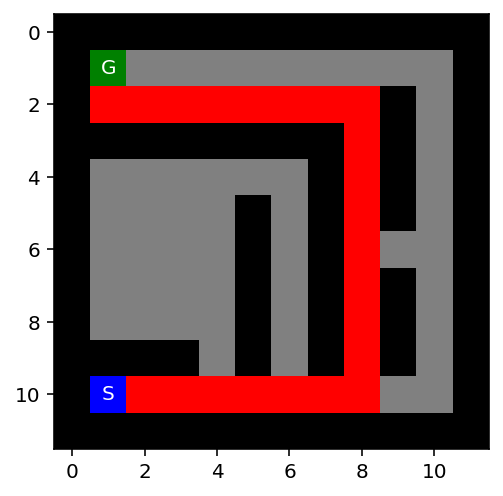

The algorithm took 71 iterations, path_cost 23
medium_maze


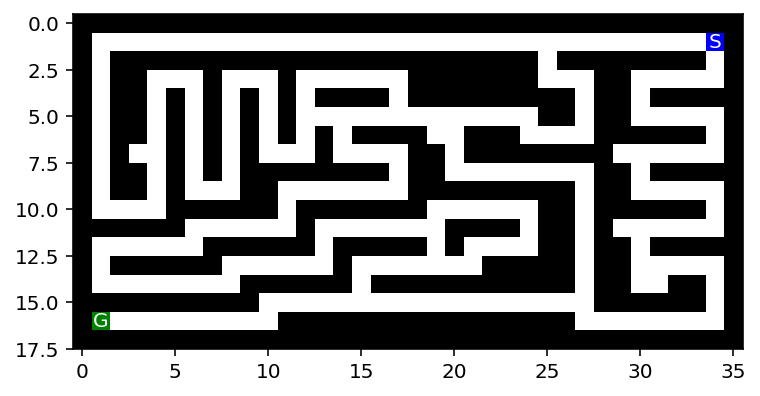

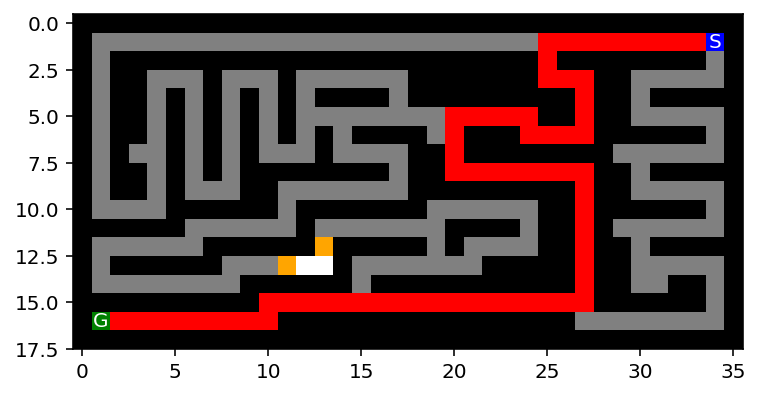

The algorithm took 269 iterations, path_cost 68
open_maze


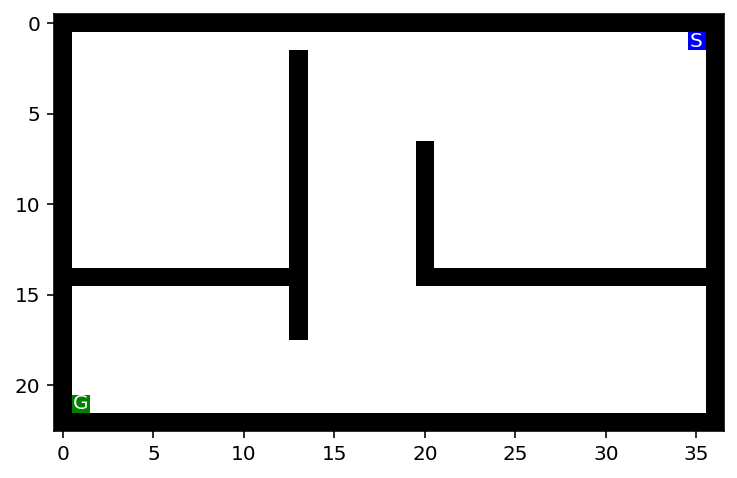

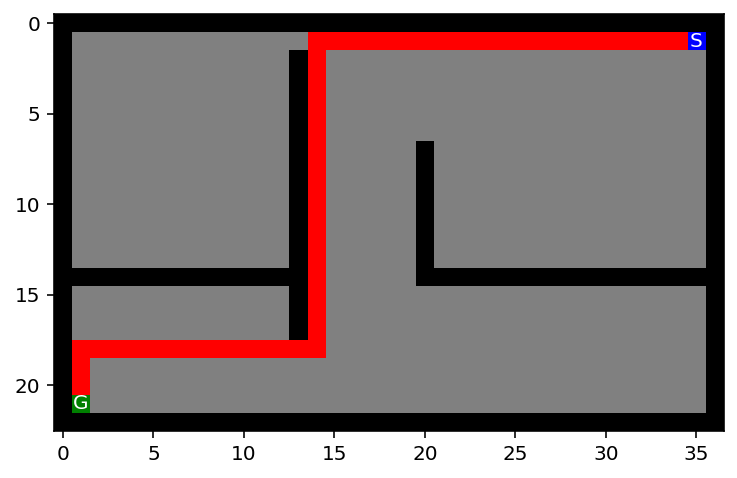

The algorithm took 683 iterations, path_cost 54
wall_maze


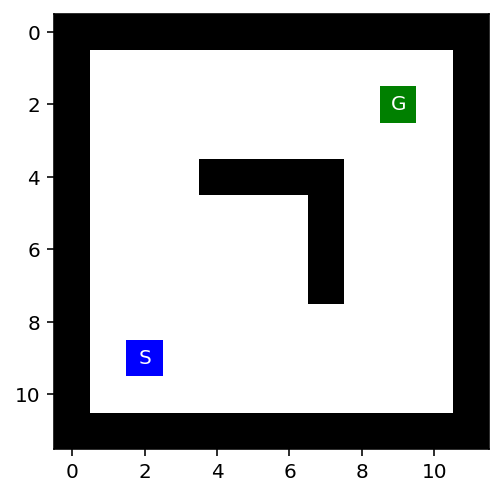

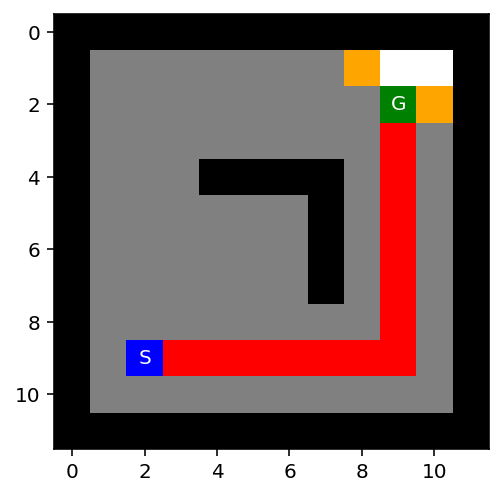

The algorithm took 88 iterations, path_cost 14


In [10]:
# will return goal node (has all path in its heiarchy, number of iterations)
def bfs(maze, verbose_text=False, verbose_maze=False, paint_end=True):
    node_x_y = find_pos(maze, what="S")
    root = Node(pos=node_x_y, parent = None, action = None, cost = 0)
    goal_x_y = find_pos(maze, what="G")
    if verbose_text:
        print(f"Starting state:\t{node_x_y}")
        print(f"Goal State:\t{goal_x_y}")
    if verbose_maze:
        show_maze(maze)
    
    if root.pos == goal_x_y:
        return root, 0, 1,1,1,1
    frontier = []
    frontier.append(root)
    reached = {}
    reached[root.pos] = root
    
    if verbose_text:
        print(f"Frontier: {len(frontier)}")
        print(strListOfNodes(frontier))
    
    iteration = 0
    tree_size = 1
    frontier_size = len(frontier)
    max_depth = 0
    while len(frontier) != 0:
        if frontier_size < len(frontier):
            frontier_size = len(frontier)
        node = frontier.pop(0)
        if node.cost > max_depth:
            max_depth = node.cost
        if node.pos == goal_x_y:
            if paint_end:
                paint_DFS(maze, reached, frontier, node)
            return node, node.cost, iteration, max_depth, tree_size, frontier_size
        if verbose_text:
            print(f"On iteration {iteration}: {node.__str__()}")
        
        #expand the popped node
        expanded = expand(maze, node)
        if verbose_text:
            print(f"Expaned List: {len(expanded)}")
            print(strListOfNodes(expanded))
            
        for child in expanded:
            s = child.pos
            if (s not in reached):
                reached[s] = child
                if verbose_text:
                    print(f"adding {s[0]},{s[1]} to the frontier")
                tree_size += 1
                frontier.append(child)
        iteration = iteration + 1
        if verbose_maze:
            show_maze(maze)
            
mazes = get_mazes(show=False)
for maze_key in mazes:
    print(maze_key)
    show_maze(mazes[maze_key])
    node, path_cost, node_expanded, max_tree_depth, max_tree_size, max_frontier_size = bfs(mazes[maze_key], verbose_text=False, verbose_maze=False)
    print(f"The algorithm took {node_expanded} iterations, path_cost {path_cost}")
    #set_path(mazes[maze_key], node)

In [11]:
#psuedo code from page 77 of book
#We are going to take this example and remove the "Limitedness" of the search
"""
function Depth-Limited-Search(problem, l) returns a node or failure or cutoff
    frontier a LIFO queue (stack) with NODE(problem.inital as an element)
    result <- failure 
    while not is-empty(frontier) do 
        node <- pop(frontier)
        if problem.Is-Goal(node.State) then return node
        if Depth(node) > l then 
            result <- cutoff
        else if not Is-Cylce(node) do 
            for each child in Expand(problem, node) do 
                ass child to fontier 
    return result
"""
def is_cylce(node, next=None):
    parent = node.parent
    #print(f"checking {node} for a cycle")
    #print(str_parents(node))
    while parent != None:
        if parent.pos == node.pos:
            #print("CYCLE FOUND")
            return True
        parent = parent.parent
    #print("CYLCE NOT FOUND")
    return False
def show_path(maze, node):
    while node is not None:
        if maze[node.pos[0]][node.pos[1]] != 'G' and maze[node.pos[0]][node.pos[1]] != 'S':
            maze[node.pos[0]][node.pos[1]] = 'P'
        for fron in node.frontier:
            if maze[fron.pos[0]][fron.pos[1]] != 'G' and maze[fron.pos[0]][fron.pos[1]] != 'S' and maze[fron.pos[0]][fron.pos[1]] != 'P':
                maze[fron.pos[0]][fron.pos[1]] = 'F'
        node = node.parent
    show_maze(maze)
def reset_path(maze):
    for x in range(len(maze)):
        for y in range(len(maze[0])):
            if maze[x][y] == 'P':
                maze[x][y] = ' '
class Node_DFS:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search
        self.frontier = []
    def __str__(self):
        str =  f"Node - pos = {self.pos}; parent = {repr(self.parent)}; action = {self.action}; cost = {self.cost};"
        str = str + "frontier"
        for fron in self.frontier:
            str =f"{str} {fron.pos},"
        return str
def add_to_fontier(node, maze, strategy='rand'):
    expanded = []
    if strategy == 'rand':
        #add all the actions to the list
        if maze[node.pos[0]][node.pos[1] + 1] != 'X':
            expanded.append(Node_DFS(pos=(node.pos[0],node.pos[1] + 1), parent=node, action='e', cost=node.cost+1))
        if maze[node.pos[0]][node.pos[1] - 1] != 'X':
            expanded.append(Node_DFS(pos=(node.pos[0],node.pos[1] - 1), parent=node, action='w', cost=node.cost+1))
        if maze[node.pos[0] - 1][node.pos[1]] != 'X':
            expanded.append(Node_DFS(pos=(node.pos[0] - 1,node.pos[1]), parent=node, action='n', cost=node.cost+1))
        if maze[node.pos[0] + 1][node.pos[1]] != 'X':
            expanded.append(Node_DFS(pos=(node.pos[0] + 1,node.pos[1]), parent=node, action='s', cost=node.cost+1))
        random.shuffle(expanded)
        node.frontier = expanded
    else: #Assuming it is in the form 'NSWE'
        for char in strategy:
            if char == 'E':
                if maze[node.pos[0]][node.pos[1] + 1] != 'X':
                    expanded.append(Node_DFS(pos=(node.pos[0],node.pos[1] + 1), parent=node, action='e', cost=node.cost+1))
            if char == 'W':
                if maze[node.pos[0]][node.pos[1] - 1] != 'X':
                    expanded.append(Node_DFS(pos=(node.pos[0],node.pos[1] - 1), parent=node, action='w', cost=node.cost+1))
            if char == 'S':
                if maze[node.pos[0] + 1][node.pos[1]] != 'X':
                    expanded.append(Node_DFS(pos=(node.pos[0] + 1,node.pos[1]), parent=node, action='s', cost=node.cost+1))
            if char == 'N':
                if maze[node.pos[0] - 1][node.pos[1]] != 'X':
                    expanded.append(Node_DFS(pos=(node.pos[0] - 1,node.pos[1]), parent=node, action='n', cost=node.cost+1))
        node.frontier = expanded    

In [12]:
# choosing options NWES, SWEN etc. and rand (random)
def dfs(maze, verbose_text=False, choosing_method='rand', verbose_maze=False, max_iterations = 10000):
    node_x_y = find_pos(maze, what="S")
    node = Node_DFS(pos=node_x_y, parent = None, action = None, cost = 0)
    goal_x_y = find_pos(maze, what="G")
    if verbose_text:
        print(f"Starting state:\t{node_x_y}")
        print(f"Goal State:\t{goal_x_y}")
    if verbose_maze:
        show_maze(maze)
    if node.pos == goal_x_y:
        return node, 0, 0, 1, 1,0
    # We are not at the goal state
    if verbose_text:
        print(f"expanding {node}")
    add_to_fontier(node, maze, choosing_method)
    if verbose_text:
        print(f"expanded {node}")
    iteration = 0
    done = False
    max_depth = 1
    nodes_expanded = 1
    tree_size = 1
    max_tree_size = tree_size
    frontier_size = 1
    max_frontier_size = frontier_size
    while iteration < max_iterations and done == False:
        # we need to go up on level
        if len(node.frontier) == 0:
            tree_size -= 1
            parent = node.parent
            node = None
            node = parent
            if verbose_text:
                print(f"** swithcing to parent dead end **")
        #expand the current frontier 
        else:
            node = node.frontier.pop(0)
            if max_depth < node.cost:
                max_depth = node.cost
            if node.pos == goal_x_y:
                return node, node.cost, nodes_expanded, max_depth, max_tree_size, max_frontier_size
            if not is_cylce(node):
                nodes_expanded += 1
                tree_size += 1
                add_to_fontier(node, maze, choosing_method)
                frontier_size += len(node.frontier)
                
                if max_frontier_size < frontier_size:
                    max_frontier_size = frontier_size
                    
                if max_tree_size < tree_size:
                    max_tree_size = tree_size
                if verbose_text:
                    print(f"expanding {node}")
                
                if verbose_text:
                    print(f"expanded {node}")
                if verbose_maze:
                    show_path(maze, node)
                    reset_path(maze)
        iteration = iteration + 1  
    return None, -1, nodes_expanded, max_tree_depth, max_tree_size, max_frontier_size 
        


In [13]:
def dfs_more_attempts(maze, verbose_text=False, choosing_method='rand', verbose_maze=False, max_iterations = 100000, attempts=10):
    iterations = 0
    for index in range(attempts):
        node, path_cost, nodes_expanded, max_tree_depth, max_tree_size, max_frontier_size = dfs(maze, verbose_text=False, choosing_method=choosing_method, verbose_maze=False, max_iterations = 100000)
        if node != None:
            return node, path_cost, nodes_expanded, max_tree_depth, max_tree_size, max_frontier_size
        else:
            iterations += max_iterations
    return None, -1, -1, -1, -1, -1

small_maze


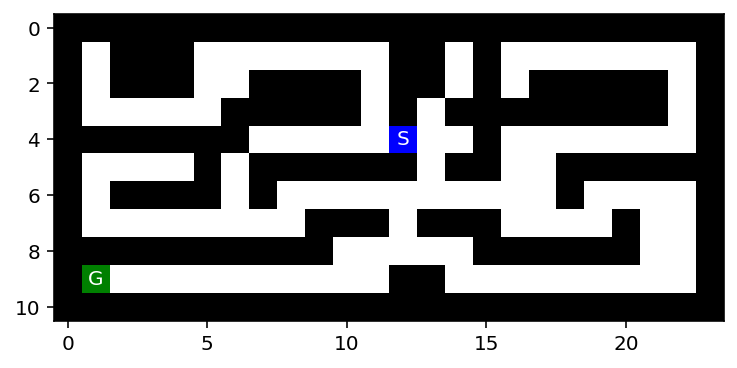

path too 53 steps


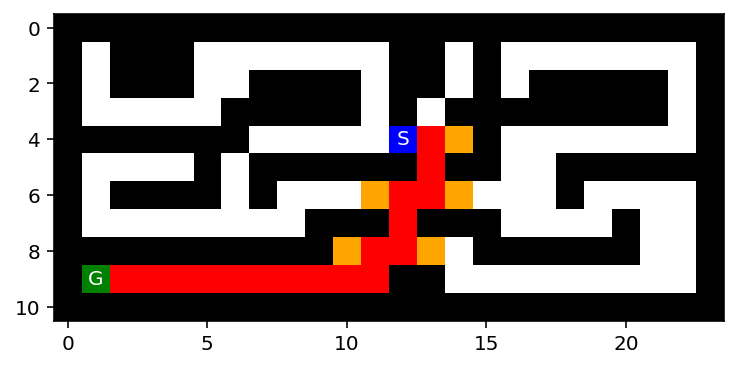

large_maze


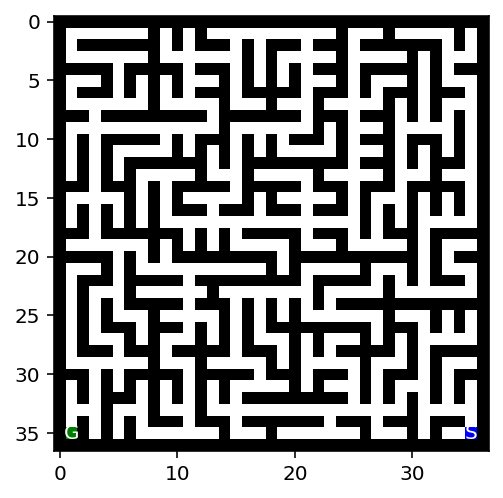

path too 469 steps


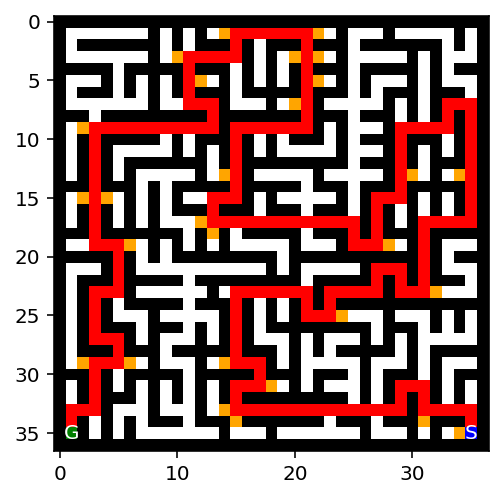

empty_maze


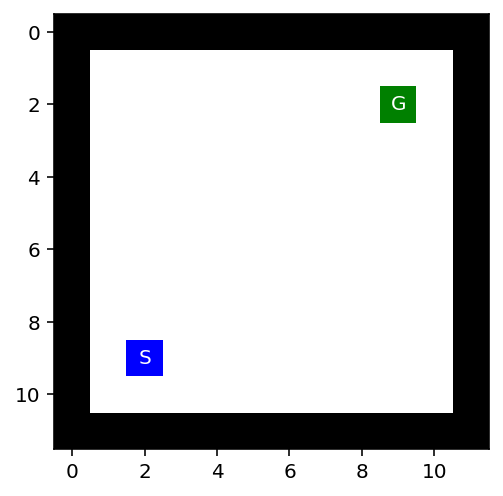

path too 88 steps


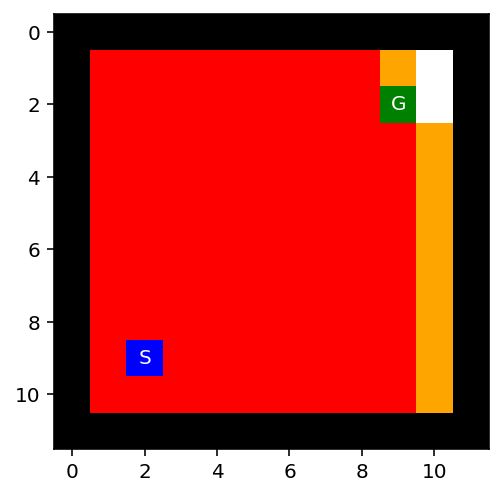

empty_2_maze


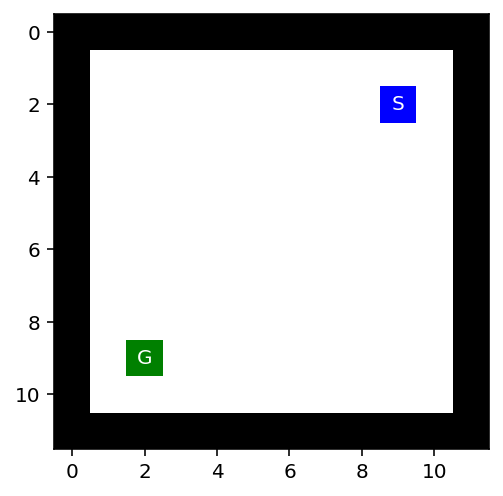

path too 70 steps


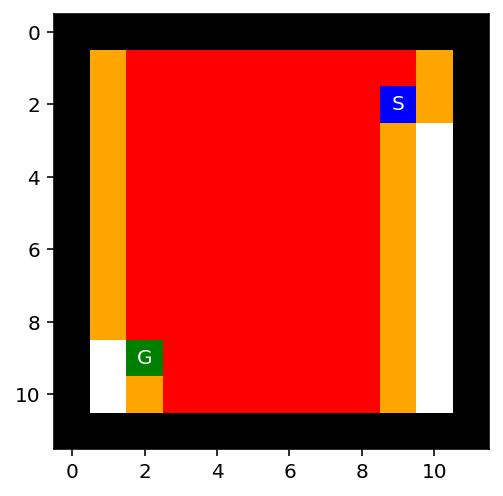

loops_maze


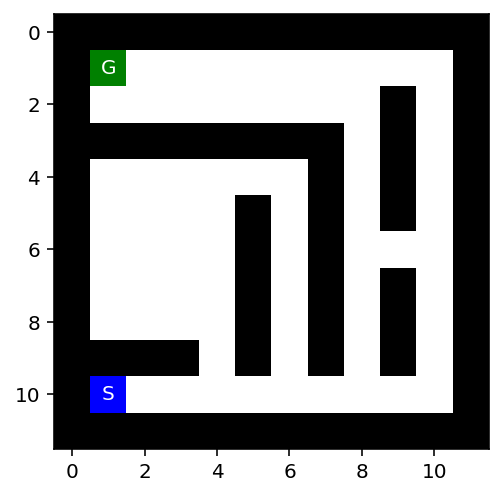

path too 1179 steps


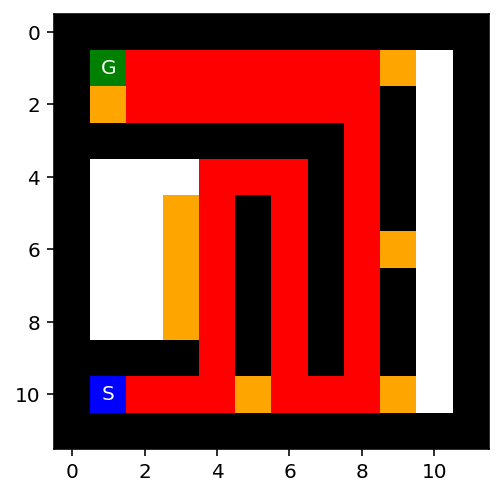

medium_maze


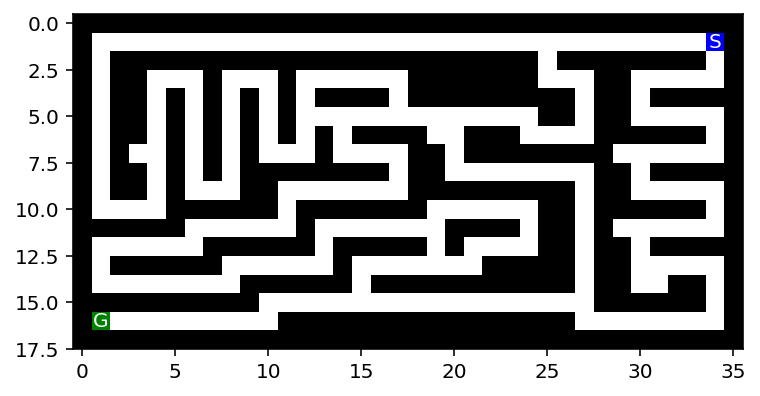

path too 258 steps


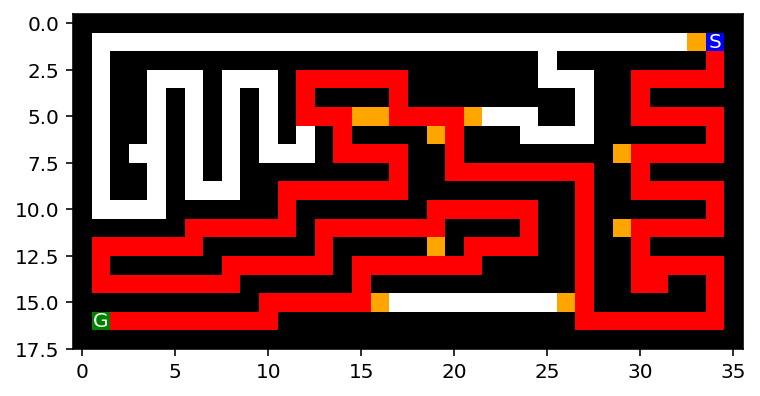

open_maze


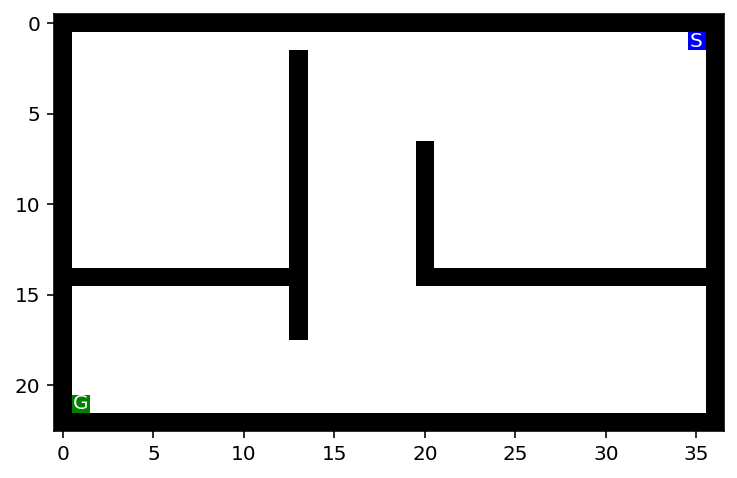

path too -1 steps


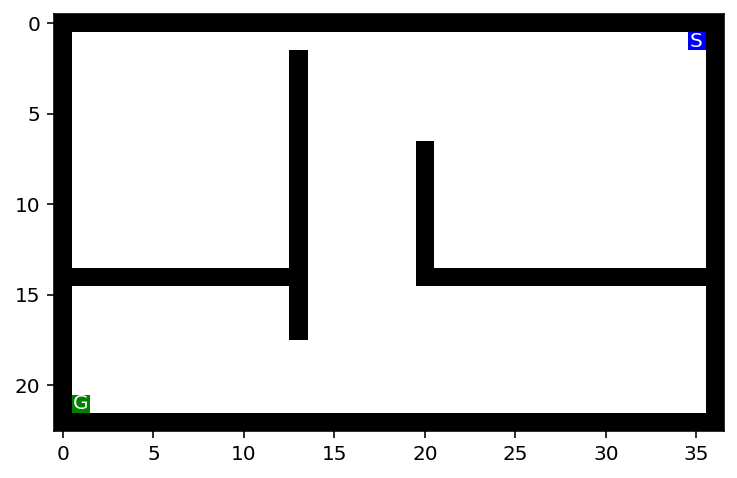

wall_maze


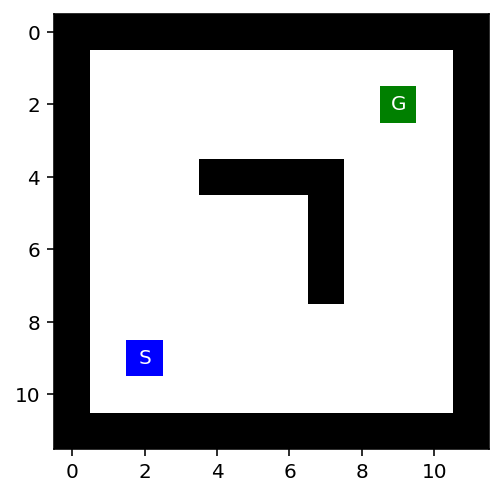

path too 12637 steps


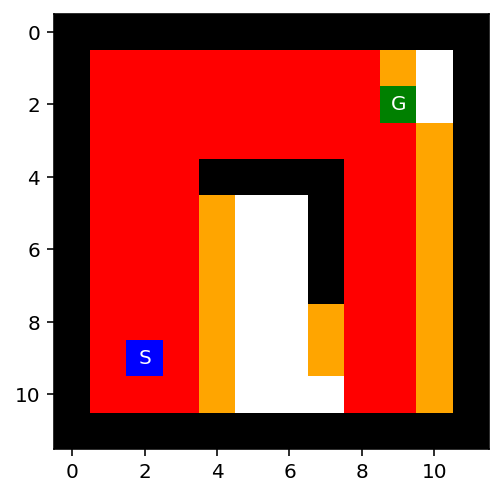

Wall time: 4.21 s


In [14]:
%%time
mazes = get_mazes()
for maze in mazes:
    print(maze)
    show_maze(mazes[maze])
    node, path_cost, nodes_expanded, max_tree_depth, max_tree_size, max_frontier_size = dfs_more_attempts(mazes[maze],verbose_text=False, choosing_method='NSWE', verbose_maze=False, attempts=1)
    print(f"path too {nodes_expanded} steps")
    show_path(mazes[maze], node)

## How do you deal with loops (cycles)?

For cycles I use the is_cycle method that I created.  This just goes up the path and ensures that there will not be cycles for this given path, when we expand a new node.  That being said, this does not stop the program from seemingly being in a loop whilst searhcing a large room like in maze "open_maze".  Above is the exectution the Stack order 'NSEW', which will generate the same result for a particular maze no matter what.  And for the "open_maze it never actually gets out of the room before the max number of iterations.  I theorize that if given enough time it would eventually ge out of the room, but it would literally have to check every single terminal path that ends in that room, which would take a very long time.  Below is a run using a random stack order and trying the program if it gets passed a maz_iterations.

small_maze


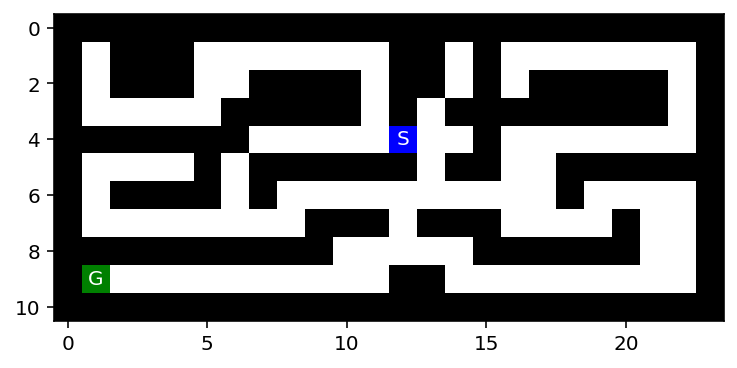

path too 38 steps


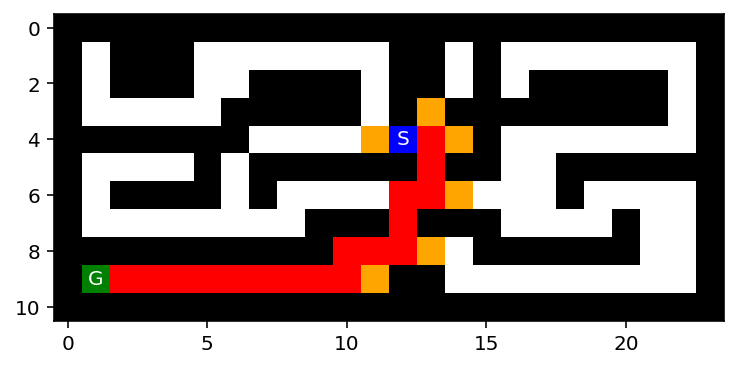

large_maze


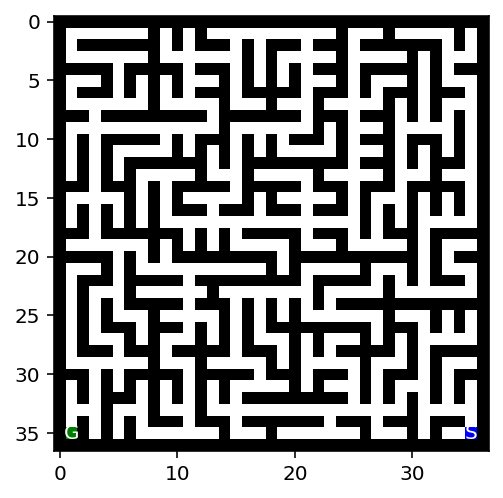

path too 413 steps


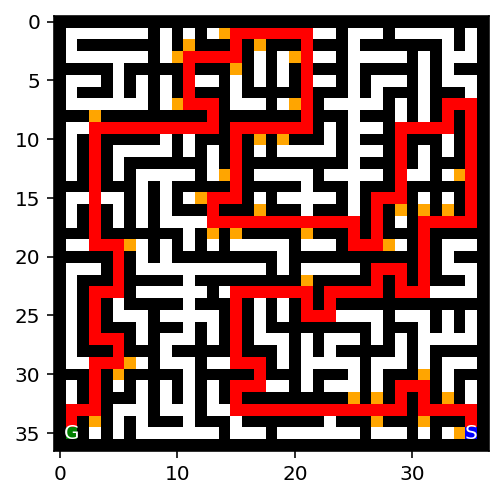

empty_maze


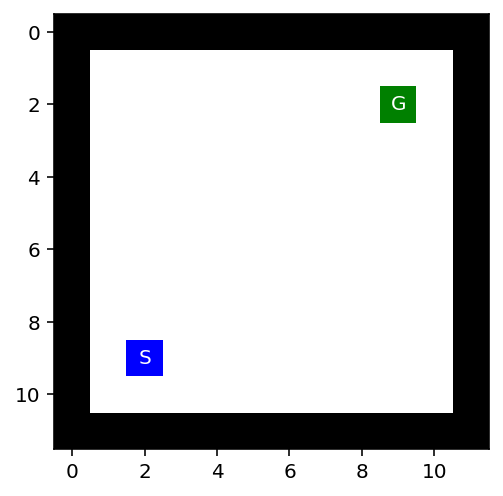

path too 68 steps


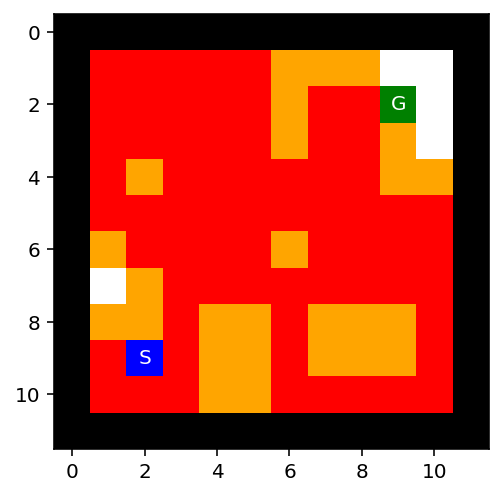

empty_2_maze


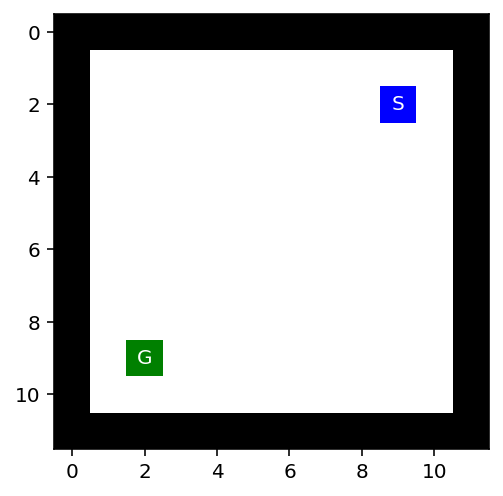

path too 39 steps


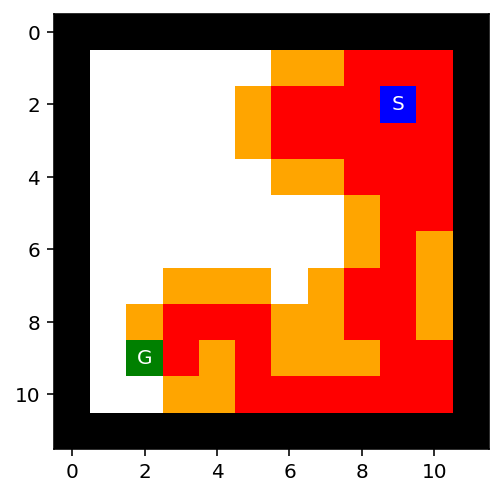

loops_maze


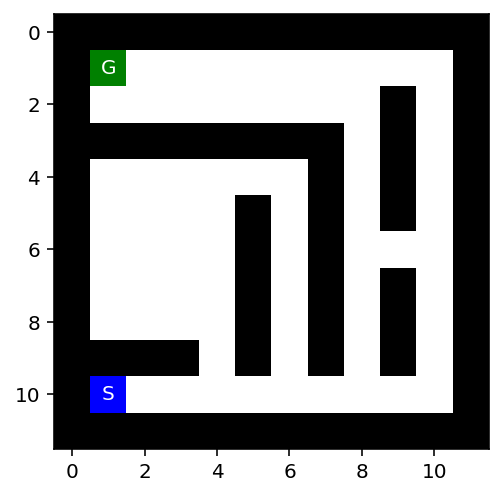

path too 32 steps


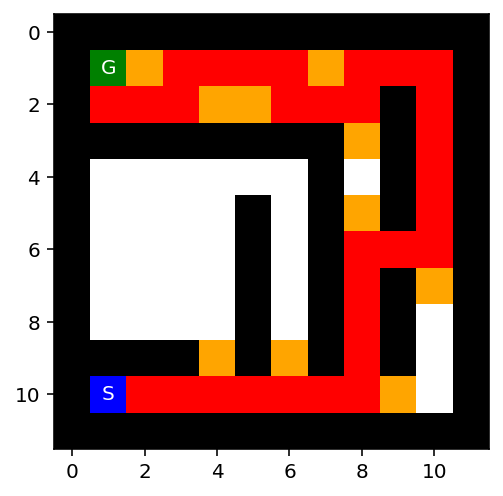

medium_maze


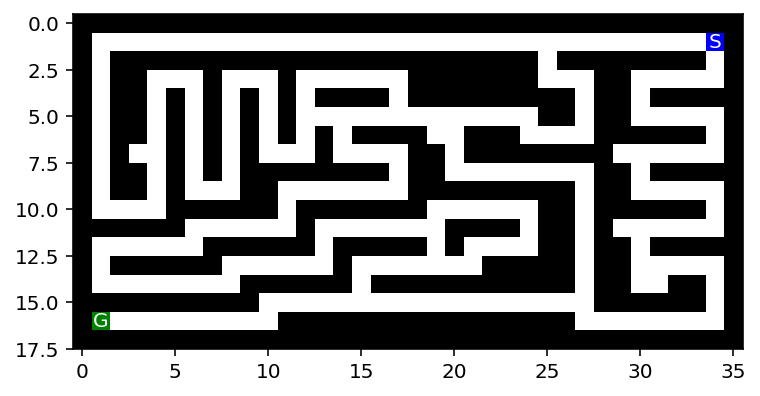

path too 361 steps


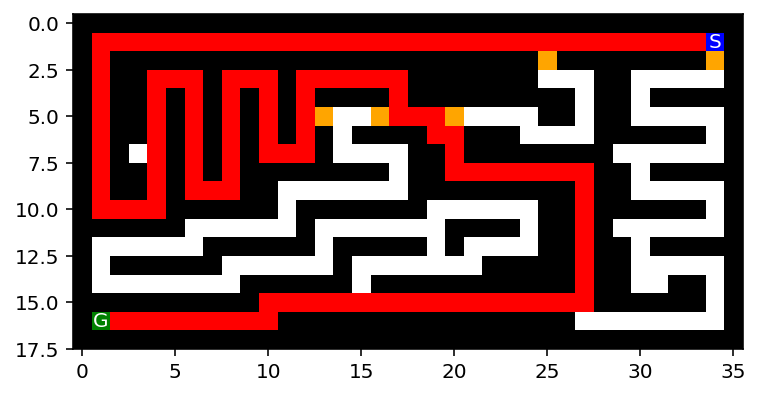

open_maze


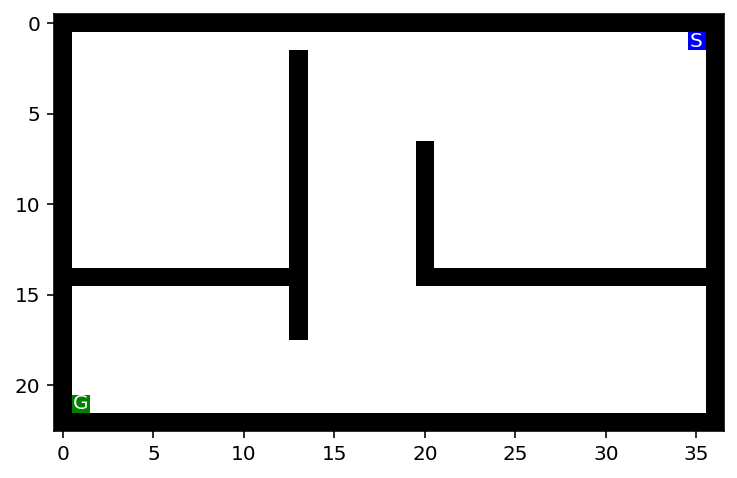

path too 239 steps


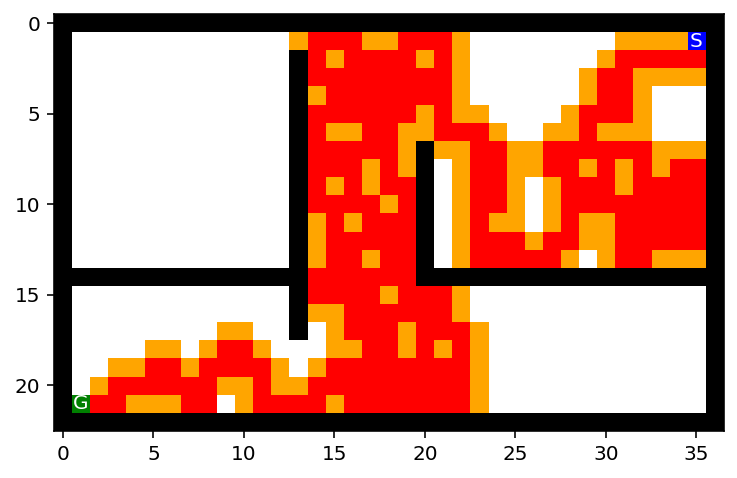

wall_maze


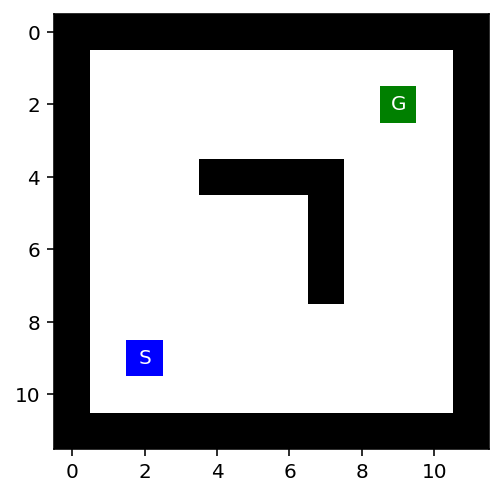

path too 129 steps


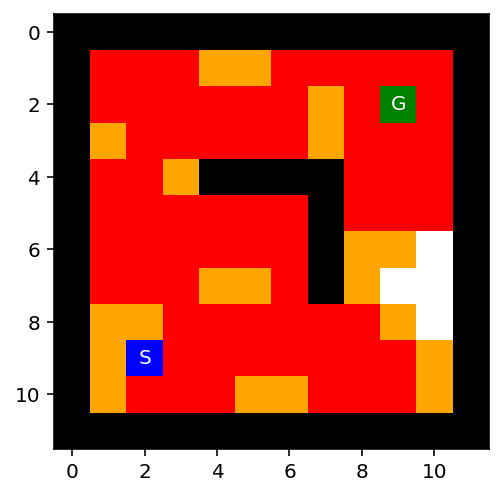

Wall time: 5.95 s


In [16]:
%%time
mazes = get_mazes()
for maze in mazes:
    print(maze)
    show_maze(mazes[maze])
    node, path_cost, nodes_expanded, max_tree_depth, max_tree_size, max_frontier_size = dfs_more_attempts(mazes[maze],verbose_text=False, choosing_method='rand', verbose_maze=False)
    print(f"path too {nodes_expanded} steps")
    show_path(mazes[maze], node)

# Cylces Continued
Above you can see this approach conquering the open_maze.  This approach also ran in half the time. While this is not an infinite loop, since eventually the algorithm will have searched all the paths in the rooms that is gets stuck in, this approach is clearly more efficient.  There is no need to continue searching thousands and thousands of paths when restarting will yeild a better result.

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?

* BFS
 * Complete: This algorithm is complete.  If there is a path it will find it.
 * Optimal: This algorithm is also optimal.  The path that is finds is guaranteed to be the best path there is, since it goes one step further at a time.
 * Time: O(b^d) where b is the branching factor and d is the depth.  Since we will have to generate b nodes at each depth and there is d depths 
 * Space: O(b^d) since all of the nodes will exist in memory this is also the space complexity
* DFS 
 * This algorithm is not complete.  As seen above the open_maze may not finish.  Even while using the random and try again method  if your max_iterations and  attempts are appropriatly calibrated to the maze you are trying to solve it may not finish.
 * This algorithm is not optimal.  Just looking at some of the results in the 'NSWE' ordering run you see the path snake up and down across the whole maze.  This is not the best path and even doing the rand method that paths are clearly not optimal.
 * Space: O(P) where P is the path of the maximum depth  Since we only ever keep the path in memory this is the most memory we will need.
 * Time, This time O(bm) where m is the maximum depth of the tree and b is the average number of children a node has.  We can quickly see how the open_maze exacerbates this b factor compared to mazes with a lot of walls.

## Task 3: Implement greedy best-first search and A* search  [4 points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function.

These are going to be the same as BFS, but instead of the frontier being a queue it is going to be a priority queue

In [17]:
def distance(pos1, pos2):
    x = pos1[0] - pos2[0]
    y = pos1[1] - pos2[1]
    return abs(x) + abs(y)

class Node_Hue:
    def __init__(self, pos, parent, action, cost, goal):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search
        self.hue_score = distance(pos, goal)
    def __lt__(self, other):
        return self.hue_score < other.hue_score
    def __str__(self):
        return f"Node Hue - pos = {self.pos}; parent = {repr(self.parent)}; action = {self.action}; cost = {self.cost}; score {self.hue_score}"
def expand_greedy(maze, node, goal):
    expanded = []
    #add all the actions to the list
    if maze[node.pos[0]][node.pos[1] + 1] != 'X':
        expanded.append(Node_Hue(pos=(node.pos[0],node.pos[1] + 1), parent=node, action='e', cost=node.cost+1, goal=goal))
    if maze[node.pos[0]][node.pos[1] - 1] != 'X':
        expanded.append(Node_Hue(pos=(node.pos[0],node.pos[1] - 1), parent=node, action='w', cost=node.cost+1, goal=goal))
    if maze[node.pos[0] - 1][node.pos[1]] != 'X':
        expanded.append(Node_Hue(pos=(node.pos[0] - 1,node.pos[1]), parent=node, action='n', cost=node.cost+1, goal=goal))
    if maze[node.pos[0] + 1][node.pos[1]] != 'X':
        expanded.append(Node_Hue(pos=(node.pos[0] + 1,node.pos[1]), parent=node, action='s', cost=node.cost+1, goal=goal))
    random.shuffle(expanded)
    return expanded


small_maze


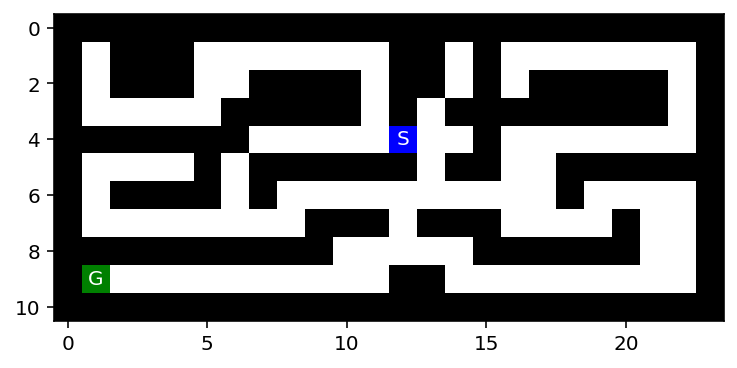

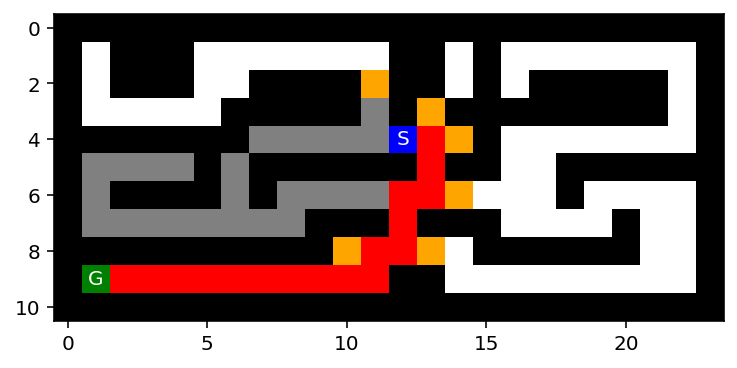

The algorithm took 18 steps
large_maze


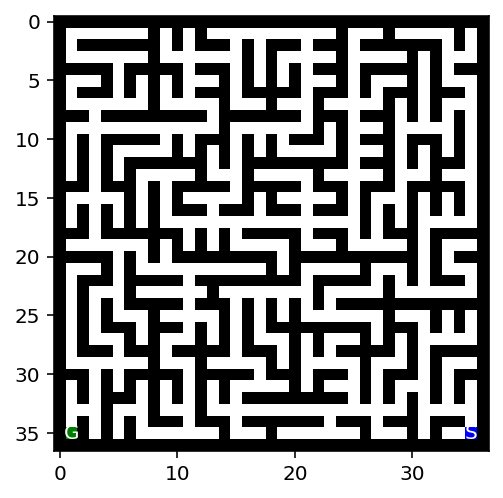

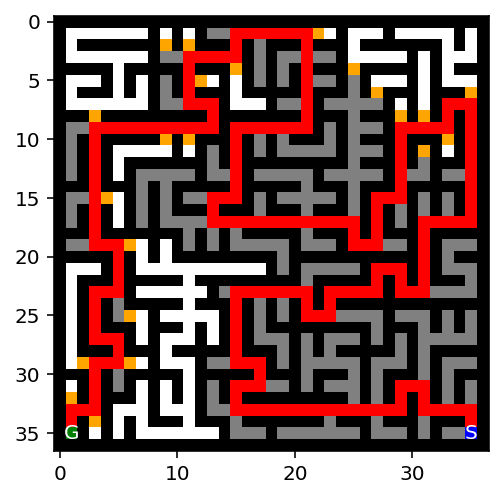

The algorithm took 210 steps
empty_maze


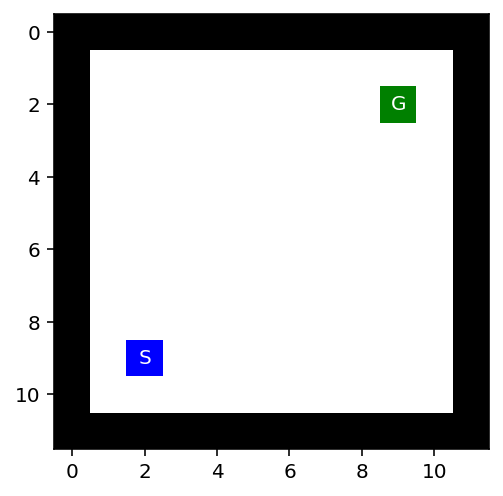

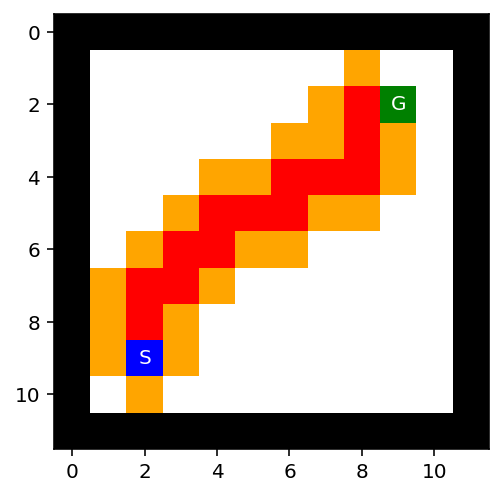

The algorithm took 14 steps
empty_2_maze


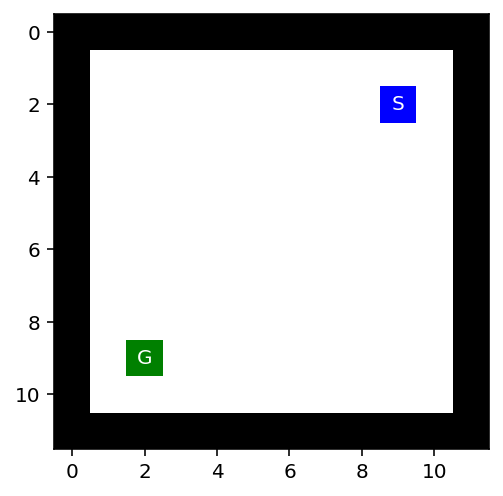

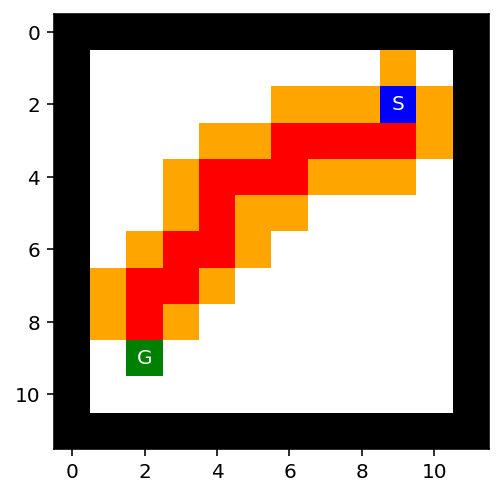

The algorithm took 14 steps
loops_maze


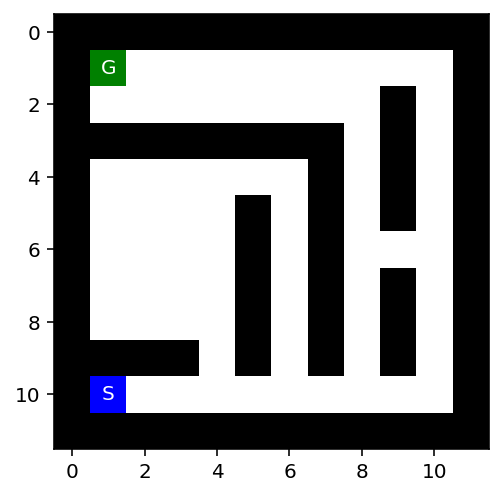

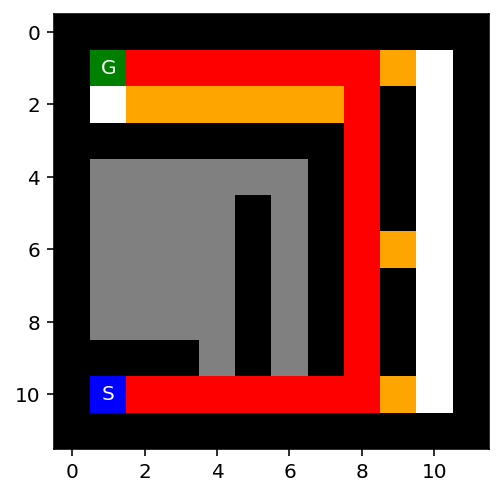

The algorithm took 23 steps
medium_maze


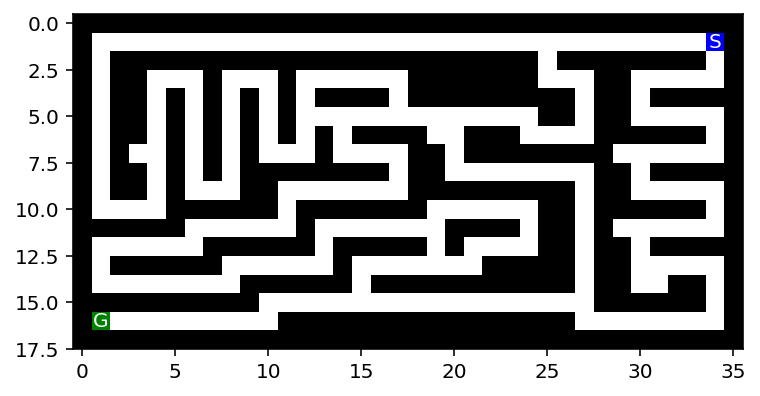

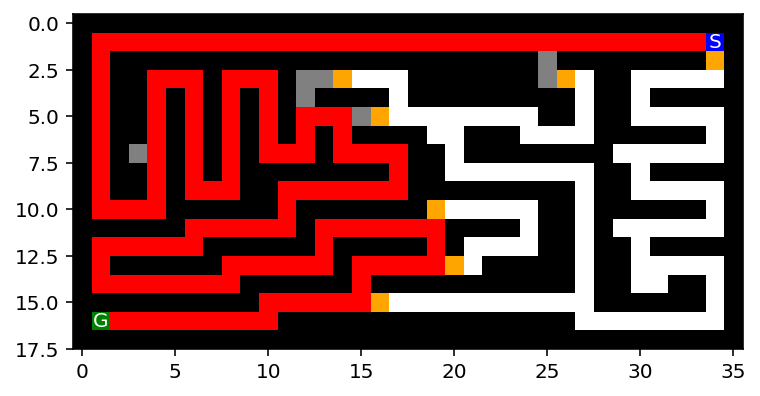

The algorithm took 152 steps
open_maze


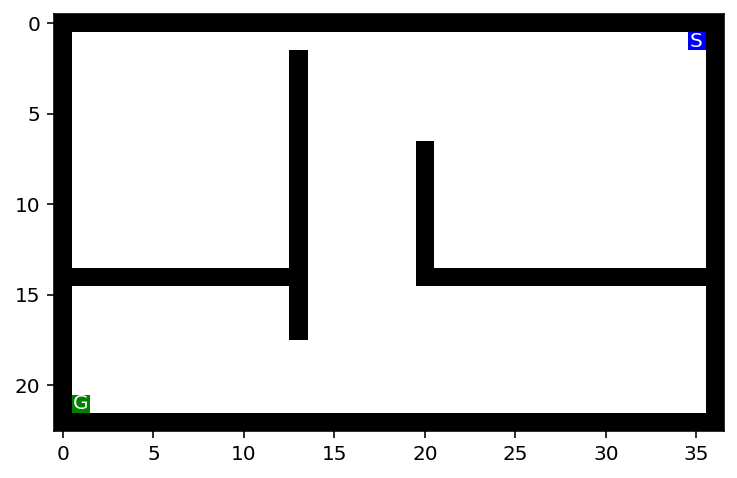

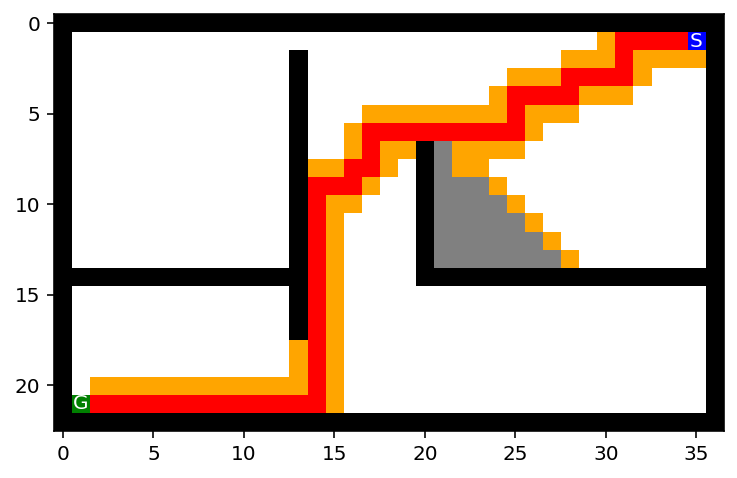

The algorithm took 54 steps
wall_maze


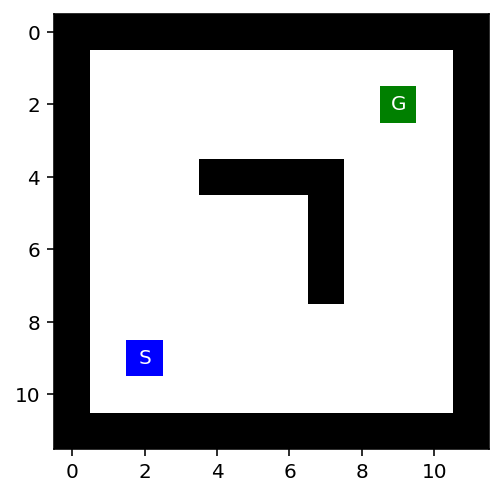

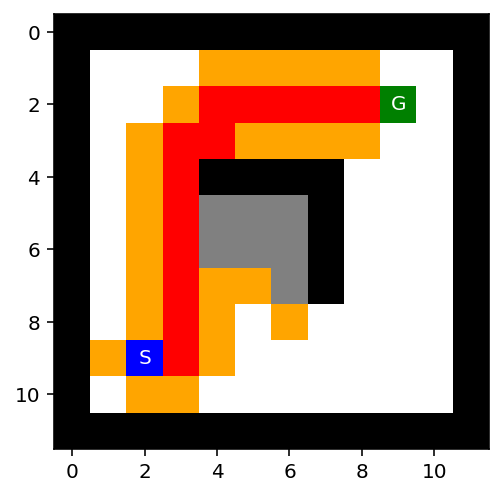

The algorithm took 14 steps
Wall time: 2.21 s


In [18]:
%%time
from queue import PriorityQueue
import copy
def paint_maze(maze, reached, frontier, node):
    for r in reached:
        if maze[r[0]][r[1]] != 'S' and maze[r[0]][r[1]] != 'G':
            maze[r[0]][r[1]] = '.'
    for f in frontier.queue:
        if maze[f[1].pos[0]][f[1].pos[1]] != 'S' and maze[f[1].pos[0]][f[1].pos[1]] != 'G':
            maze[f[1].pos[0]][f[1].pos[1]] = 'F'
    while node != None:
        if maze[node.pos[0]][node.pos[1]] != 'S' and maze[node.pos[0]][node.pos[1]] != 'G':
            maze[node.pos[0]][node.pos[1]] = 'P'
        node = node.parent
        
    show_maze(maze)
def greed_best_first(maze, verbose_text=False, verbose_maze=False, paint_at_end=True):
    node_x_y = find_pos(maze, what="S")
    goal_x_y = find_pos(maze, what="G")
    root = Node_Hue(pos=node_x_y, parent = None, action = None, cost = 0, goal=goal_x_y)
    if verbose_text:
        print(f"Starting state:\t{node_x_y}")
        print(f"Goal State:\t{goal_x_y}")
    if verbose_maze:
        show_maze(maze)
    
    if root.pos == goal_x_y:
        return root, 0, 0
    frontier = PriorityQueue()
    frontier.put((root.hue_score, root))
    reached = {}
    reached[root.pos] = root
    
    if verbose_text:
        print(f"Frontier: {frontier.qsize()}")
        #print(strListOfNodes(frontier))
    
    nodes_expanded = 0
    max_tree_depth = 1
    tree_size = 1
    max_frontier = 1
    while not frontier.empty():
        node = frontier.get()[1]
        nodes_expanded = nodes_expanded + 1
        if frontier.qsize() > max_frontier:
            max_frontier = frontier.qsize()
        reached[node.pos] = node
        if max_tree_depth < node.cost:
            max_tree_depth = node.cost
        if verbose_text:
            print(f"On iteration {iteration}: {node.__str__()}| Frontier: {frontier.qsize()} ")
        if node.pos == goal_x_y:
            if paint_at_end:
                paint_maze(maze, reached, frontier, node)
            return node, node.cost, nodes_expanded, max_tree_depth, tree_size, max_frontier
    
        #expand the popped node
        expanded = expand_greedy(maze, node, goal_x_y)
        if verbose_text:
            print(f"Expaned List: {len(expanded)}")
            print(strListOfNodes(expanded))
            
        for child in expanded:
            s = child.pos
            tree_size += 1
            if verbose_text:
                for key, value in reached.items():
                    print(key, ' : ', value)
            if (s not in reached) and maze[s[0]][s[1]] != 'S':
                if verbose_text:
                    print(f"adding {child} to the frontier")
                frontier.put((child.hue_score, child))
        if verbose_text:
            print(f"finished iteration {iteration} and Frontier {frontier.qsize()} and isEmpty {frontier.empty()}")
        
        if verbose_maze:
            paint_maze(maze, reached, frontier, node)
mazes = get_mazes()
for maze_key in mazes:
    print(maze_key)
    show_maze(mazes[maze_key])
    node, steps, nodes_expanded, max_tree_depth, tree_size, max_frontier = greed_best_first(mazes[maze_key], verbose_text=False, verbose_maze=False)
    print(f"The algorithm took {steps} steps")

    

small_maze


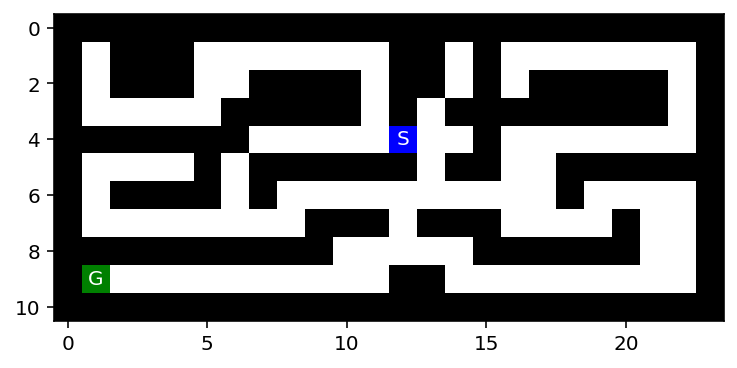

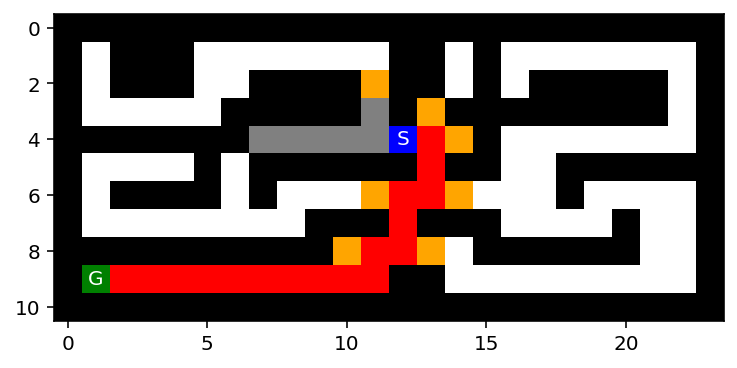

The algorithm took 18 steps
large_maze


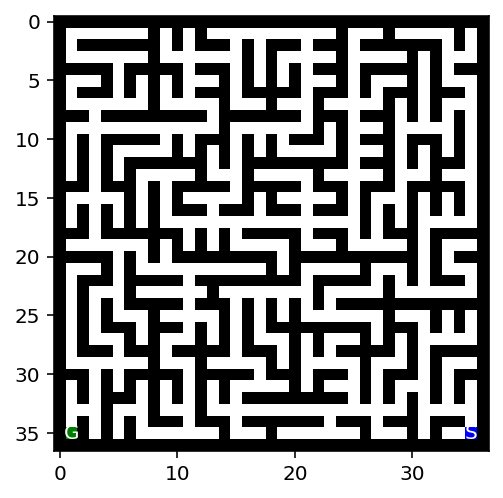

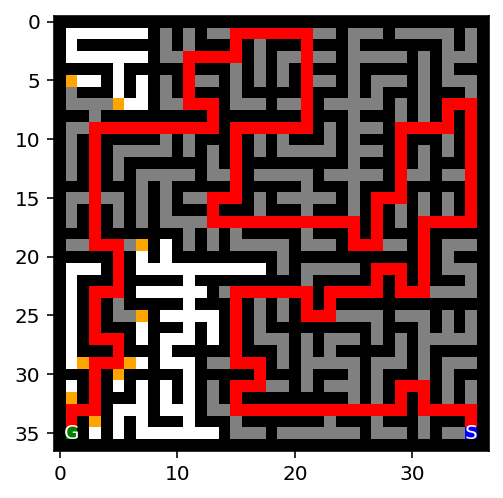

The algorithm took 210 steps
empty_maze


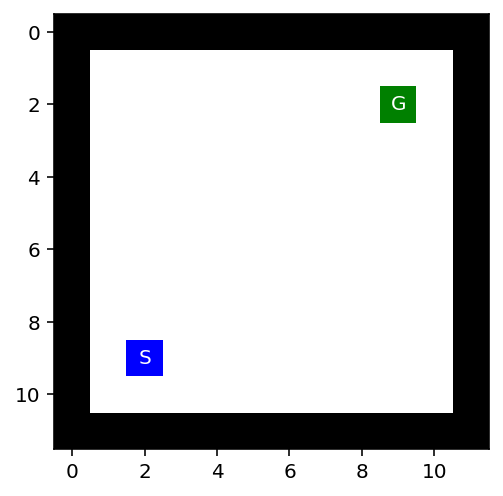

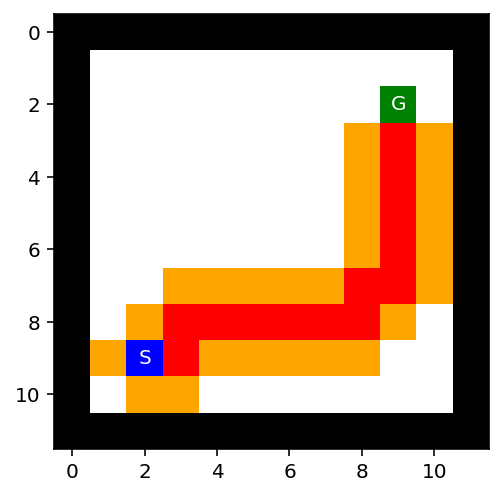

The algorithm took 14 steps
empty_2_maze


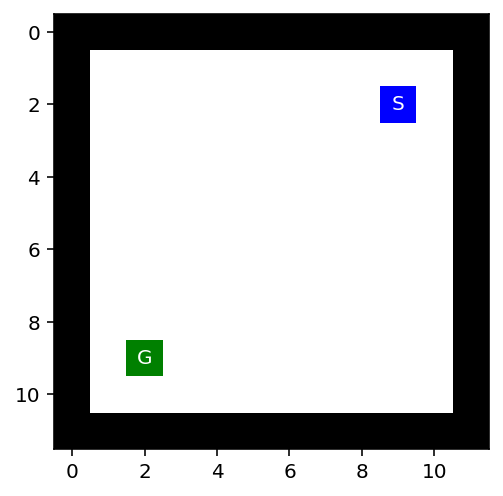

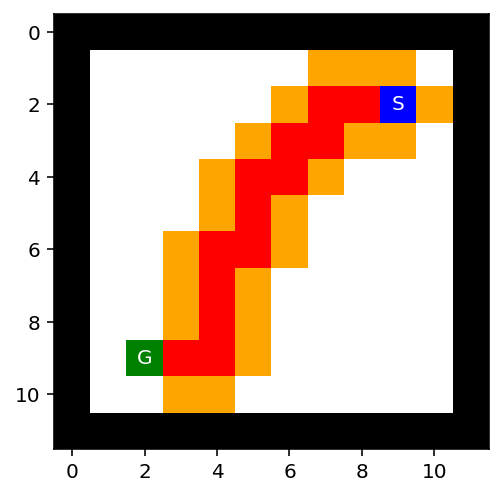

The algorithm took 14 steps
loops_maze


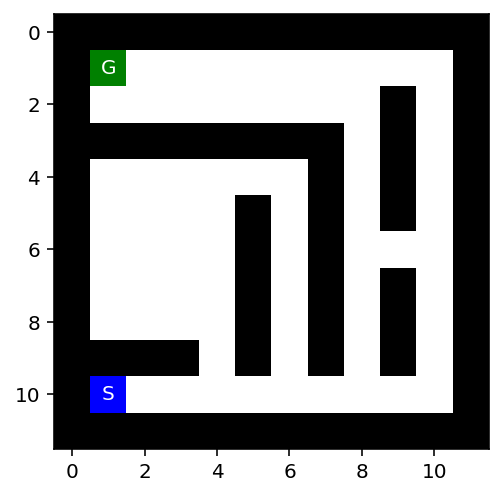

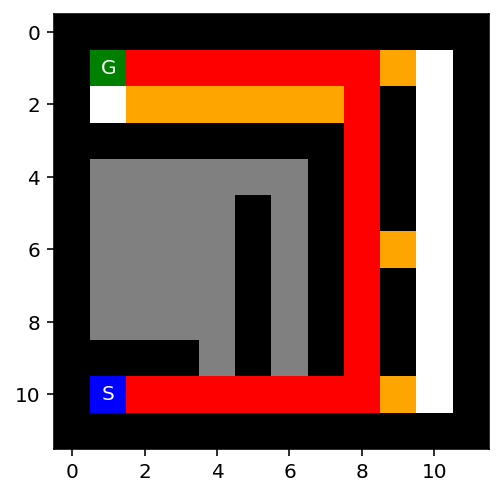

The algorithm took 23 steps
medium_maze


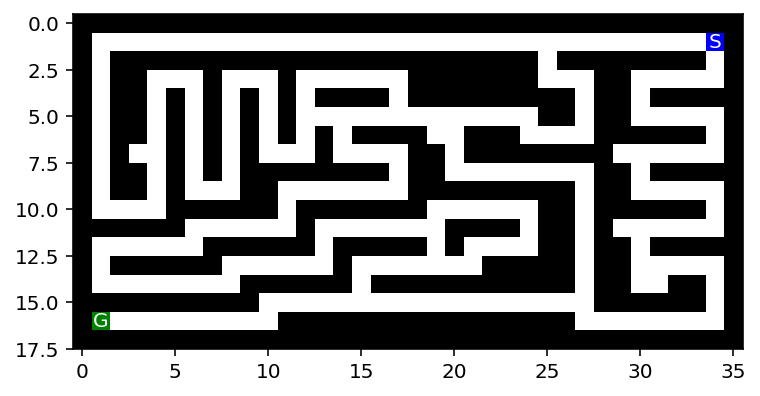

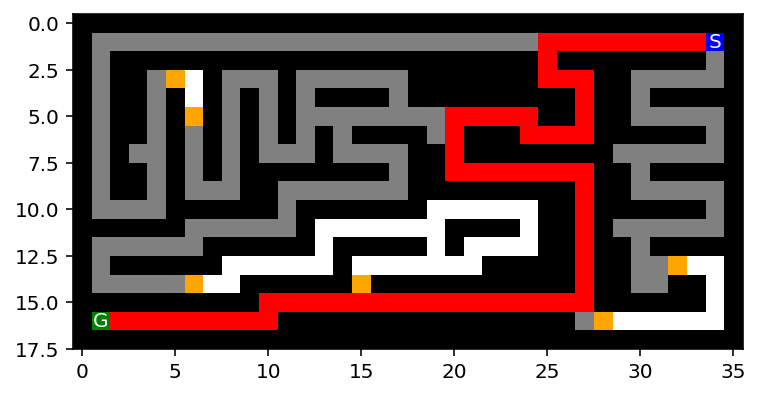

The algorithm took 68 steps
open_maze


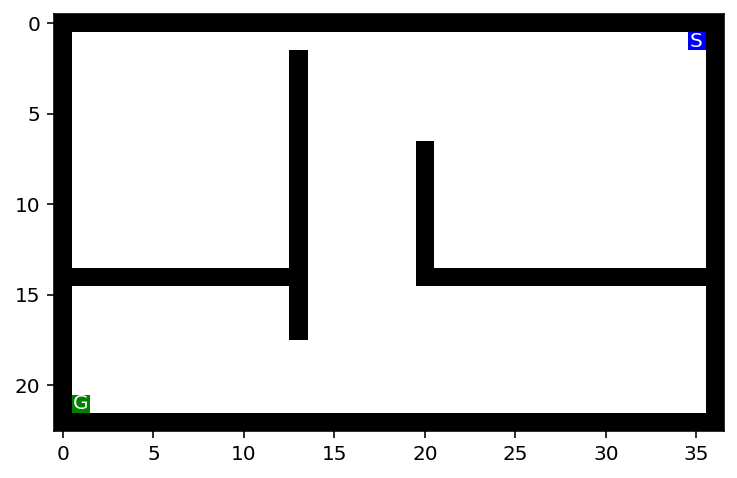

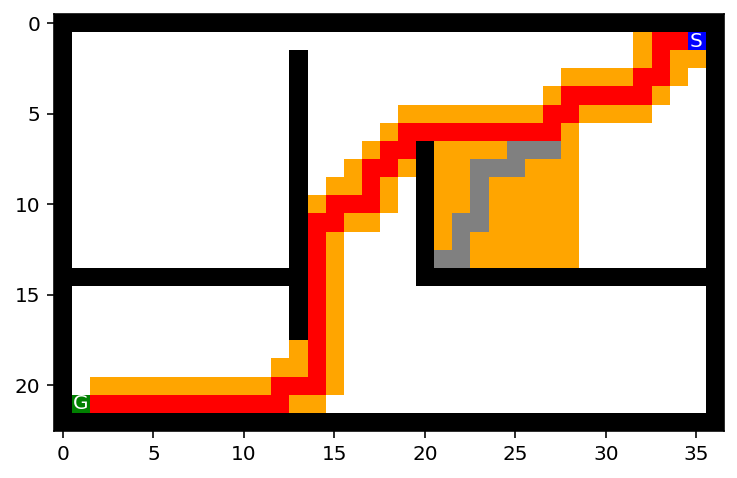

The algorithm took 54 steps
wall_maze


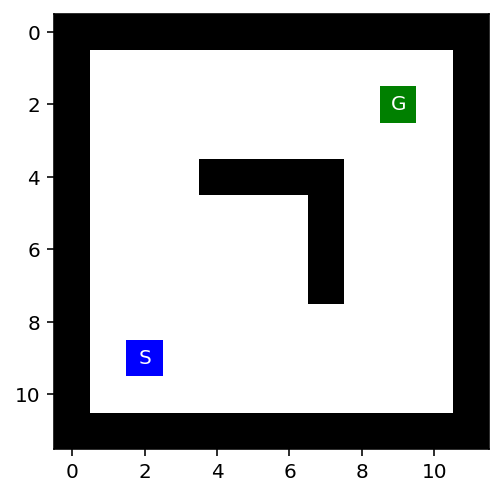

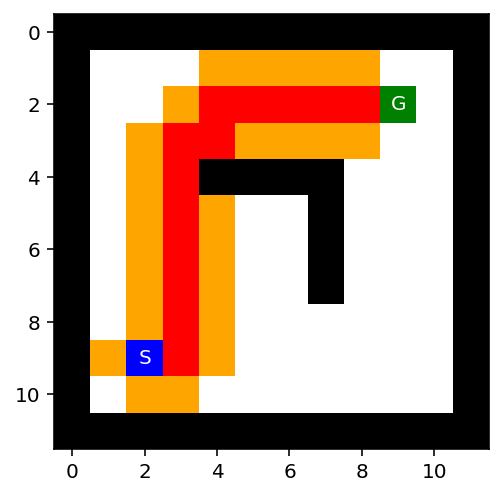

The algorithm took 14 steps
Wall time: 2.16 s


In [19]:
%%time
def a_star(maze, verbose_text=False, verbose_maze=False, paint_at_end=True):
    node_x_y = find_pos(maze, what="S")
    goal_x_y = find_pos(maze, what="G")
    root = Node_Hue(pos=node_x_y, parent = None, action = None, cost = 0, goal=goal_x_y)
    if verbose_text:
        print(f"Starting state:\t{node_x_y}")
        print(f"Goal State:\t{goal_x_y}")
    if verbose_maze:
        show_maze(maze)
    
    if root.pos == goal_x_y:
        return root, 0, 0, 0, 0, 0 
    frontier = PriorityQueue()
    frontier.put((root.hue_score + 0, root))
    reached = {}
    reached[root.pos] = root
    
    if verbose_text:
        print(f"Frontier: {frontier.qsize()}")
        #print(strListOfNodes(frontier))
    
    iteration = 0
    nodes_expanded = 1
    max_tree_depth = 1
    tree_size = 0
    max_frontier = 0
    while not frontier.empty():
        node = frontier.get()[1]
        if node.cost > max_tree_depth:
            max_tree_depth = node.cost
        if frontier.qsize() > max_frontier:
            max_frontier = frontier.qsize()
        nodes_expanded += 1
        reached[node.pos] = node
        if verbose_text:
            print(f"On iteration {iteration}: {node.__str__()}| Frontier: {frontier.qsize()} ")
        if node.pos == goal_x_y:
            if paint_at_end:
                paint_maze(maze, reached, frontier, node)
            return node, node.cost, nodes_expanded, max_tree_depth, tree_size, max_frontier
    
        #expand the popped node
        expanded = expand_greedy(maze, node, goal_x_y)
        if verbose_text:
            print(f"Expaned List: {len(expanded)}")
            print(strListOfNodes(expanded))
            
        for child in expanded:
            s = child.pos
            if verbose_text:
                for key, value in reached.items():
                    print(key, ' : ', value)
            if (s not in reached) and maze[s[0]][s[1]] != 'S':
                if verbose_text:
                    print(f"adding {child} to the frontier")
                frontier.put((child.hue_score + child.cost, child))
                tree_size += 1
        if verbose_text:
            print(f"finished iteration {iteration} and Frontier {frontier.qsize()} and isEmpty {frontier.empty()}")
        iteration = iteration + 1
        if verbose_maze:
            paint_maze(maze, reached, frontier, node)
mazes = get_mazes()
for maze_key in mazes:
    print(maze_key)
    show_maze(mazes[maze_key])
    node, path_length, nodes_expanded, max_tree_depth, tree_size, max_frontier = a_star(mazes[maze_key], verbose_text=False, verbose_maze=False)
    print(f"The algorithm took {path_length} steps")

Are your implementations complete and optimal? What is the time and space complexity?

Greed Best First:
* Complete: Greedy Best First is complete.  If there is a reachable goal state it will find it
* Optimal: Not always.  The algorithm can be tricked to go down paths that may not be optimal.
* Time/Space: In the worst case this algorithm will perform in O(S) where s is the number of states or for mazes the number of valid spaces

A* Search:
* Complete: Yes.  If there is a solution this algorithm will find it
* Optimal: Yes, this algroithm will find the optimal solution.  This is due to the heuristic we chose is admissible, or never overestimates the distance to the goal.
Both:
* Time/Space: In the worst case these algorithm will perform in O(S) where s is the number of states or for mazes the number of valid spaces

## Task 4: Comparison and discussion [2 points] 

Run experiments to compare the implemented algorithms and present the results as tables and charts.

In [20]:
import pandas as pd
def run_sim(show_mazes=False):
    data = []
    mazes = get_mazes()
    #print("|Algorithm \t|path cost \t|nodes exp \t|max tree depth \t|max tree size  \t|frontier size")
    for maze_key in mazes:
        
        
        if(show_mazes):
            show_maze(mazes[maze_key])
        node, bfs_l, bfs_n_exp, bfs_mtd, bfs_ts, bfs_max_f = bfs(mazes[maze_key], verbose_text=False, verbose_maze=False,paint_end=False)
        data.append(['BFS', maze_key, bfs_l, bfs_n_exp, bfs_mtd, bfs_ts, bfs_max_f])
        node, dfs_l, dfs_n_exp, dfs_mtd, dfs_ts, dfs_max_f = dfs_more_attempts(mazes[maze_key],verbose_text=False, choosing_method='rand', verbose_maze=False,max_iterations = 1000000, attempts=10)
        data.append(['DFS', maze_key, dfs_l, dfs_n_exp, dfs_mtd, dfs_ts, dfs_max_f])
        node, g_l, g_n_exp, g_mtd, g_ts, g_max_f = greed_best_first(mazes[maze_key],verbose_text=False, verbose_maze=False,paint_at_end=False)
        data.append(['Greedy Best', maze_key, g_l, g_n_exp, g_mtd, g_ts, g_max_f])  
        node, a_l, a_n_exp, a_mtd, a_ts, a_max_f = a_star(mazes[maze_key],verbose_text=False, verbose_maze=False,paint_at_end=False)
        data.append(['A Star', maze_key, a_l, a_n_exp, a_mtd, a_ts, a_max_f])
    return pd.DataFrame(data, columns = ['search_strat',
                                   'maze',
                                   'path_cost',
                                   'nodes_expanded',
                                   'max_tree_depth',
                                   'max_tree_size',
                                   'max_frontier_size'])
df = run_sim()   
display(df.groupby(['search_strat','maze']).mean())

path_cost  nodes_expanded  max_tree_depth  \
search_strat maze                                                      
A Star       empty_2_maze         14              16              14   
             empty_maze           14              16              14   
             large_maze          210             539             210   
             loops_maze           23              68              23   
             medium_maze          68             224              68   
             open_maze            54             140              54   
             small_maze           18              38              18   
             wall_maze            14              25              14   
BFS          empty_2_maze         14              95              14   
             empty_maze           14              95              14   
             large_maze          210             622             210   
             loops_maze           23              71              23   
             medium_maze          68             269              68   
             open_maze            54             683              54   
             small_maze           18              99              18   
             wall_maze            14              88              14   
DFS          empty_2_maze         50            3429              70   
             empty_maze           64              72              64   
             large_maze          210             356             215   
             loops_maze           41              43              41   
             medium_maze         150             165             150   
             open_maze           192             289             192   
             small_maze           44              97              44   
             wall_maze            34              34              34   
Greedy Best  empty_2_maze         14              15              14   
             empty_maze           14              15              14   
             large_maze          210             457             210   
             loops_maze           23             102              24   
             medium_maze         152             160             152   
             open_maze            68             193              68   
             small_maze           18              25              18   
             wall_maze            14              24              14   

                           max_tree_size  max_frontier_size  
search_strat maze                                            
A Star       empty_2_maze             43                 29  
             empty_maze               43                 29  
             large_maze              545                 13  
             loops_maze               76                 14  
             medium_maze             229                  7  
             open_maze               297                159  
             small_maze               45                  9  
             wall_maze                56                 33  
BFS          empty_2_maze             98                 12  
             empty_maze               98                 12  
             large_maze              626                  8  
             loops_maze               72                  7  
             medium_maze             272                  8  
             open_maze               684                 23  
             small_maze              103                  8  
             wall_maze                91                 11  
DFS          empty_2_maze             33              11201  
             empty_maze               21                260  
             large_maze               24                752  
             loops_maze               12                114  
             medium_maze              62                340  
             open_maze                54               1052  
             small_maze                8                210  
             wall_maze      

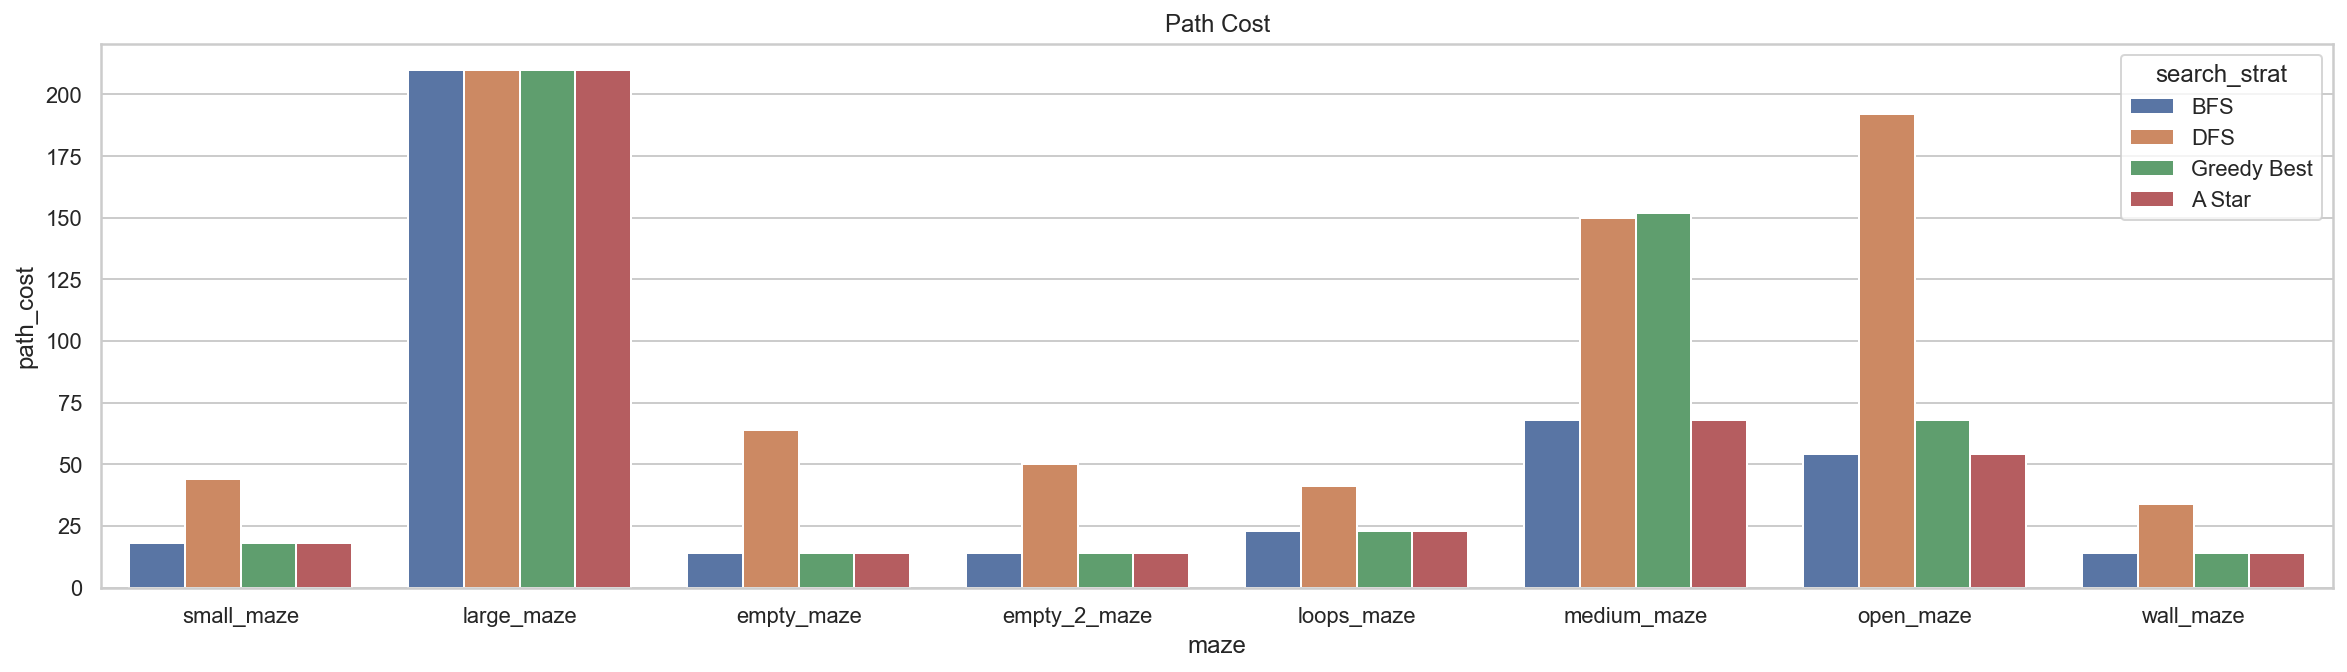

In [21]:
import seaborn as sns
plt.figure(figsize=(20,5))

sns.set_theme(style="whitegrid")
ax = sns.barplot(x="maze", y="path_cost", data=df, hue='search_strat')
ax.title.set_text('Path Cost')


This chart is interesting, for one you can see that no search algorithm can beat the A* search in path cost.  It iwll tie with BFS (they both find the optimal).  You can also see DFS do particularly bad on this front.

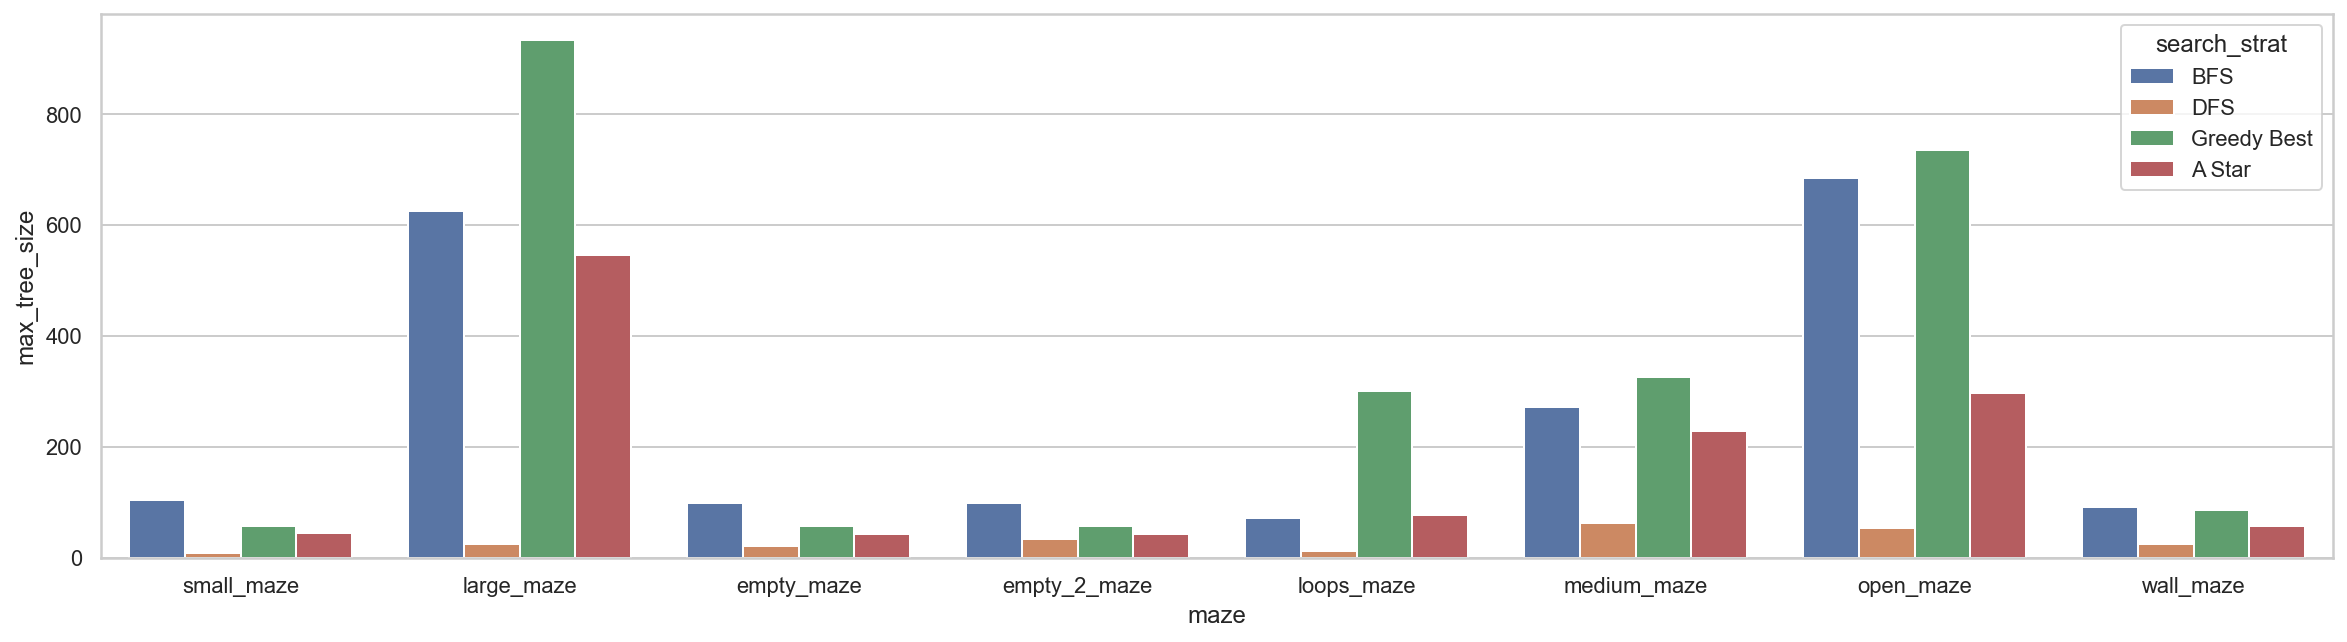

In [22]:
plt.figure(figsize=(20,5))
sns.set_theme(style="whitegrid")
ax2 = sns.barplot(x="maze", y="max_tree_size", data=df, hue='search_strat')
ax.title.set_text('Max Tree Size')

As expected the DFS is extremely memory efficent.  Especially in the case of the open maze.  Disclaimer this algorithm only kreturns data on the successful run of DFS.  Even that being the case sense the DFS search will try again it seems well worth and if that was a concern the max_iterations parameter would be chosen with the systems memory in mind.  Another interesting take away is Greed Best First Search cleary gets lost/stuck in non fruitful paths.  

### Discuss the most important lessons you have learned from implementing the different search strategies. 
I got stuck for a long time as did a lot of students with the DFS.  The problem was I knew that it wasn't in an infinte loop, because I ran it for hours and checked that each terminal path was unique.  With that logic in mind I assumed it would eventually finish even if it got stuck in that room.  The algorithm is more stable if the direction is chosen ar random (instead of the same order every time) and the process is restarted if it fails. 

## Graduate student advanced task: Multiple Goals [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

Create a few mazes with multiple goals by adding one or two more goals to the medium size maze.
Solve the maze with your implementations for DFS, BFS, and implement IDS (iterative deepening search using DFS). Run experiments to show which implementations find the optimal solution.

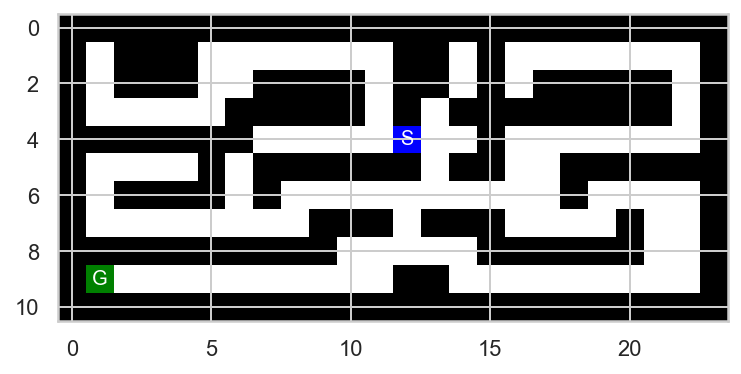

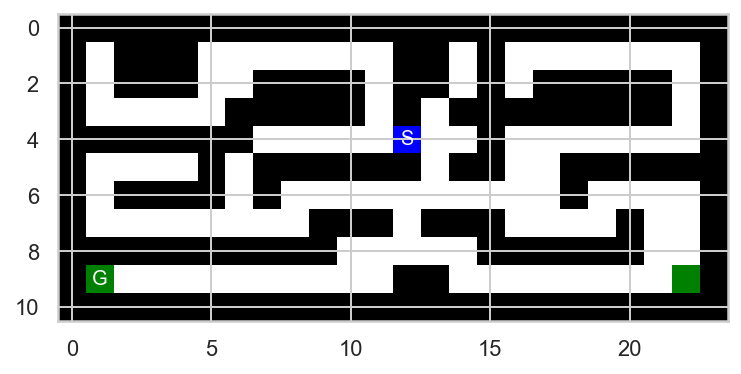

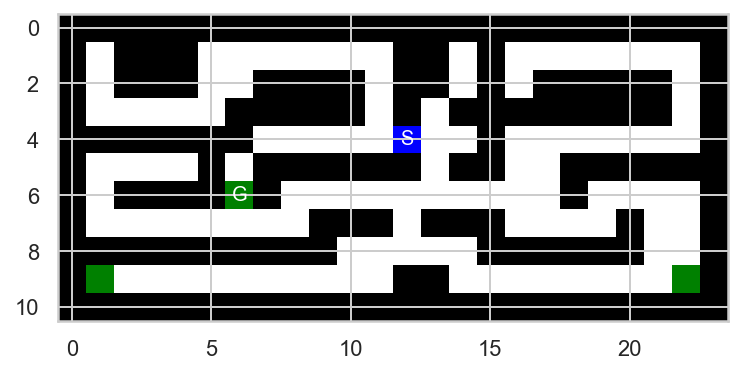

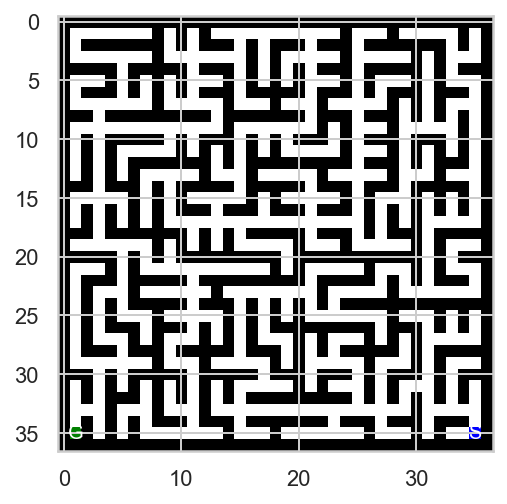

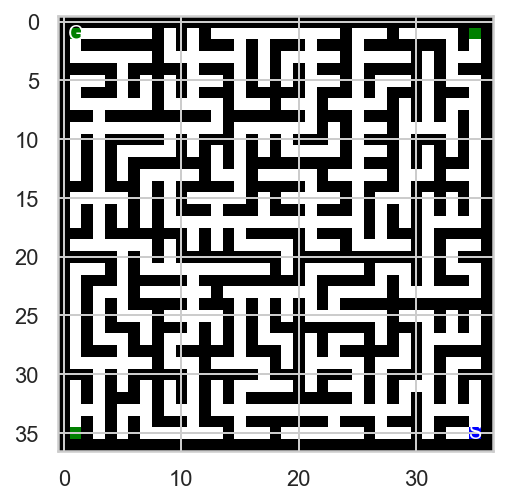

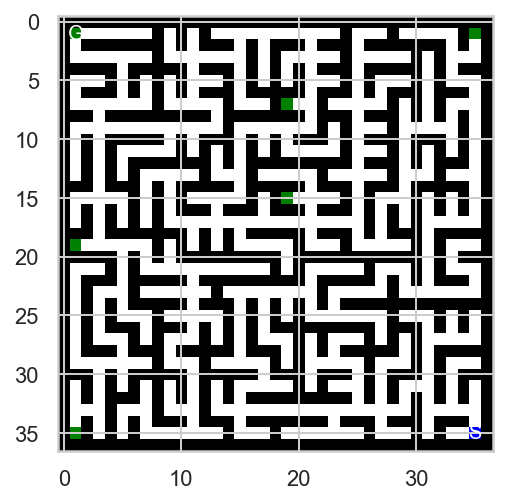

In [23]:
#Code to get more mazes with more goals
def get_mazes_many_goals(show = False):
    mazes = {}
    f = open("more_goals\small_maze_original.txt", "r")
    small_maze_str = f.read()
    mazes["small_maze_original"] = parse_maze(small_maze_str)
    if show: show_maze(mazes["small_maze_original"])
    
    f = open("more_goals\small_maze.txt", "r")
    small_maze_str = f.read()
    mazes["small_maze"] = parse_maze(small_maze_str)
    if show: show_maze(mazes["small_maze"])
        
    f = open("more_goals\small_maze2.txt", "r")
    small_maze_str = f.read()
    mazes["small_maze2"] = parse_maze(small_maze_str)
    if show: show_maze(mazes["small_maze2"])
   
    f = open("more_goals\large_maze_original.txt", "r")
    small_maze_str = f.read()
    mazes["large_maze_original"] = parse_maze(small_maze_str)
    if show: show_maze(mazes["large_maze_original"])

    f = open("more_goals\large_maze.txt", "r")
    small_maze_str = f.read()
    mazes["large_maze"] = parse_maze(small_maze_str)
    if show: show_maze(mazes["large_maze"])
        
    f = open("more_goals\large_maze2.txt", "r")
    small_maze_str = f.read()
    mazes["large_maze2"] = parse_maze(small_maze_str)
    if show: show_maze(mazes["large_maze2"])
    return mazes

              
get_mazes_many_goals(show=True)
print()

(9, 1)


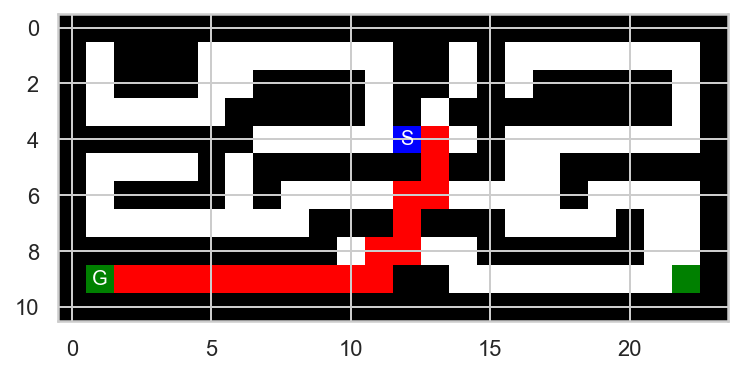

In [24]:
def exapnded_random(node, maze):
    expanded = []
    #add all the actions to the list
    if maze[node.pos[0]][node.pos[1] + 1] != 'X':
        expanded.append(Node_DFS(pos=(node.pos[0],node.pos[1] + 1), parent=node, action='e', cost=node.cost+1))
    if maze[node.pos[0]][node.pos[1] - 1] != 'X':
        expanded.append(Node_DFS(pos=(node.pos[0],node.pos[1] - 1), parent=node, action='w', cost=node.cost+1))
    if maze[node.pos[0] - 1][node.pos[1]] != 'X':
        expanded.append(Node_DFS(pos=(node.pos[0] - 1,node.pos[1]), parent=node, action='n', cost=node.cost+1))
    if maze[node.pos[0] + 1][node.pos[1]] != 'X':
        expanded.append(Node_DFS(pos=(node.pos[0] + 1,node.pos[1]), parent=node, action='s', cost=node.cost+1))
    random.shuffle(expanded)
    return expanded
def IDS(maze, max_depth):
    for depth in range(max_depth):
        node, path_cost, nodes_expanded,max_depth,max_tree_size,max_frontier_size  = DFS_Limited(maze, depth, verbose_maze=False)
        if node != None:
            return node, path_cost, nodes_expanded,max_depth,max_tree_size,max_frontier_size
    return None
def DFS_Limited(maze,  max_depth, verbose_text=False, choosing_method='rand', verbose_maze=False):
    node_x_y = find_pos(maze, what="S")
    node = Node_DFS(pos=node_x_y, parent = None, action = None, cost = 0)
    goal_x_y = find_pos(maze, what="G")
    if verbose_text:
        print(f"Starting state:\t{node_x_y}")
        print(f"Goal State:\t{goal_x_y}")
    if verbose_maze:
        show_maze(maze)
    if goal_x_y == node_x_y:
        return node, 0,1,1,1,1
    nodes_expanded = 1
    
    frontier = exapnded_random(node, maze)
    max_frontier_size = len(frontier)
    max_tree_size = 1
    tree_size = 1
    while len(frontier) != 0:
        if verbose_maze:
            print(F"MAX DEPTH{max_depth}")
            reset_path(maze)
            paint_DFS(maze, [], [], node)
            print(len(frontier))
        node = frontier.pop(0)
        nodes_expanded += 1
        if len(frontier) > max_frontier_size:
            max_frontier_size = len(frontier)
        if node.cost > max_tree_size:
            max_tree_size = node.cost  
        exp = exapnded_random(node, maze)
       
        
        if node.pos == goal_x_y:
            return node, node.cost, nodes_expanded,max_depth,max_tree_size,max_frontier_size
        #remove one from the tree counter          
        for e in exp:
            if not is_cylce(e) and e.cost < max_depth:
                frontier.append(e)
    return None, -1, nodes_expanded, max_tree_depth, max_tree_size, max_frontier_size 
mazes = get_mazes_many_goals()
node = IDS(mazes['small_maze'], 100000)
print(node[0].pos)
reset_path(maze)
paint_DFS(mazes['small_maze'], [], [], node[0])


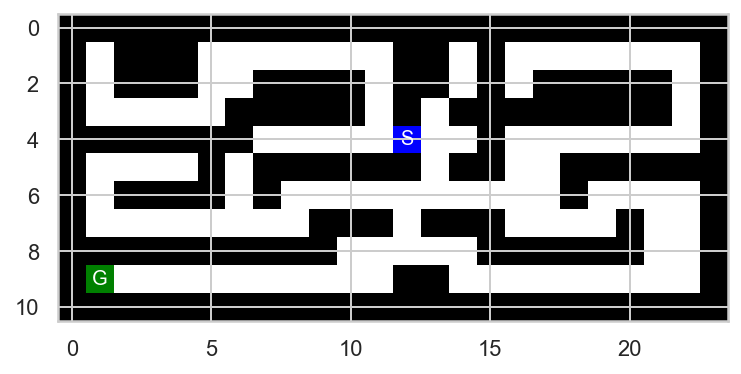

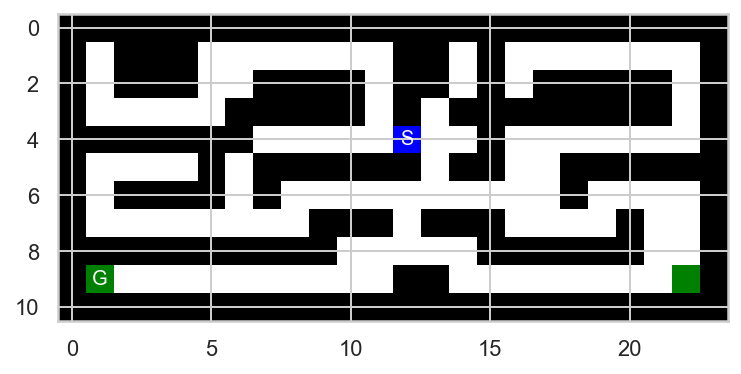

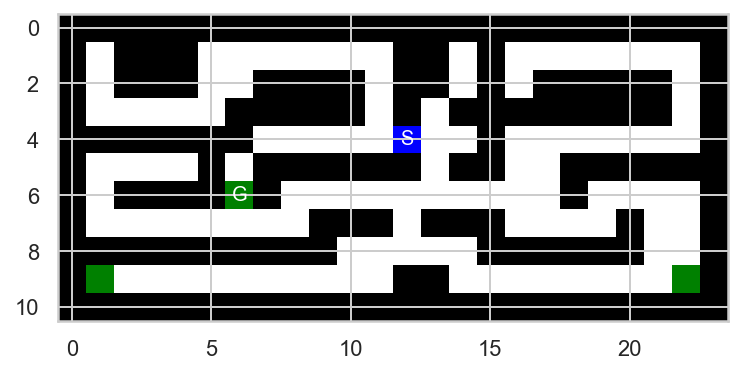

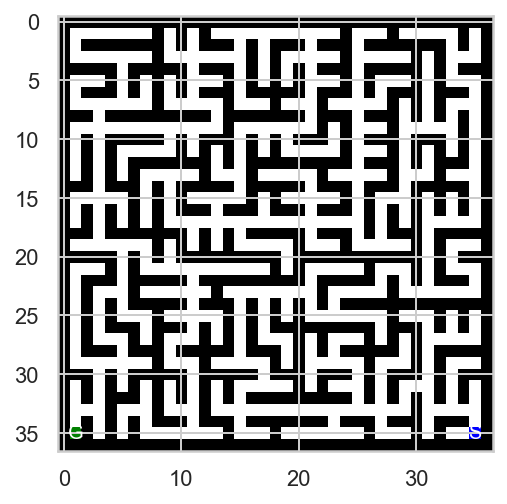

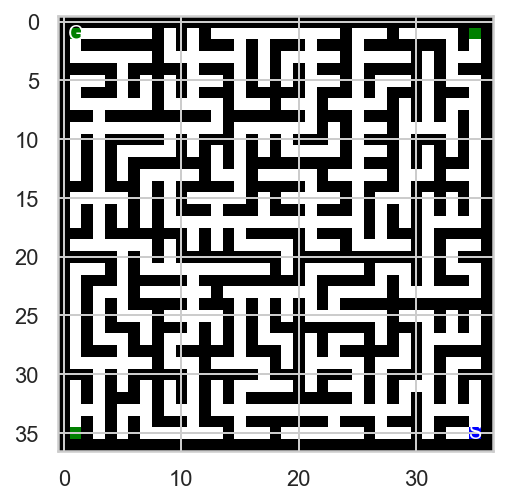

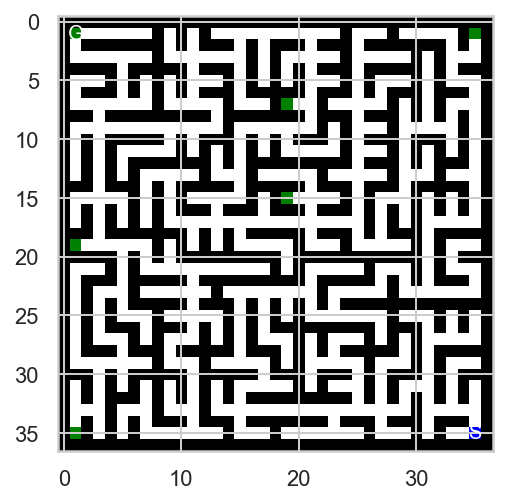

,search_strat,maze,path_cost,nodes_expanded,max_tree_depth,max_tree_size,max_frontier_size
0,BFS,small_maze_original,18,99,18,103,8
1,DFS,small_maze_original,18,1505,51,7,3244
2,IDS,small_maze_original,18,271,19,18,43
3,BFS,small_maze,18,99,18,103,8
4,DFS,small_maze,46,64,46,15,143
5,IDS,small_maze,18,268,19,18,43
6,BFS,small_maze2,12,61,12,68,8
7,DFS,small_maze2,38,40,38,18,92
8,IDS,small_maze2,12,111,13,12,20
9,BFS,large_maze_original,210,622,210,626,8


In [25]:
def run_sim_many_goals(show_mazes=False):
    data = []
    mazes = get_mazes_many_goals()
    for maze_key in mazes:
        
        
        if(show_mazes):
            show_maze(mazes[maze_key])
        node, bfs_l, bfs_n_exp, bfs_mtd, bfs_ts, bfs_max_f = bfs(mazes[maze_key], verbose_text=False, verbose_maze=False,paint_end=False)
        data.append(['BFS', maze_key, bfs_l, bfs_n_exp, bfs_mtd, bfs_ts, bfs_max_f])
        node, dfs_l, dfs_n_exp, dfs_mtd, dfs_ts, dfs_max_f = dfs_more_attempts(mazes[maze_key],verbose_text=False, choosing_method='rand', verbose_maze=False,max_iterations = 1000000, attempts=10)
        data.append(['DFS', maze_key, dfs_l, dfs_n_exp, dfs_mtd, dfs_ts, dfs_max_f])
        node, g_l, g_n_exp, g_mtd, g_ts, g_max_f = IDS(mazes[maze_key],1000)
        data.append(['IDS', maze_key, g_l, g_n_exp, g_mtd, g_ts, g_max_f])  
    return pd.DataFrame(data, columns = ['search_strat',
                                   'maze',
                                   'path_cost',
                                   'nodes_expanded',
                                   'max_tree_depth',
                                   'max_tree_size',
                                   'max_frontier_size'])
df = run_sim_many_goals(show_mazes=True)
df

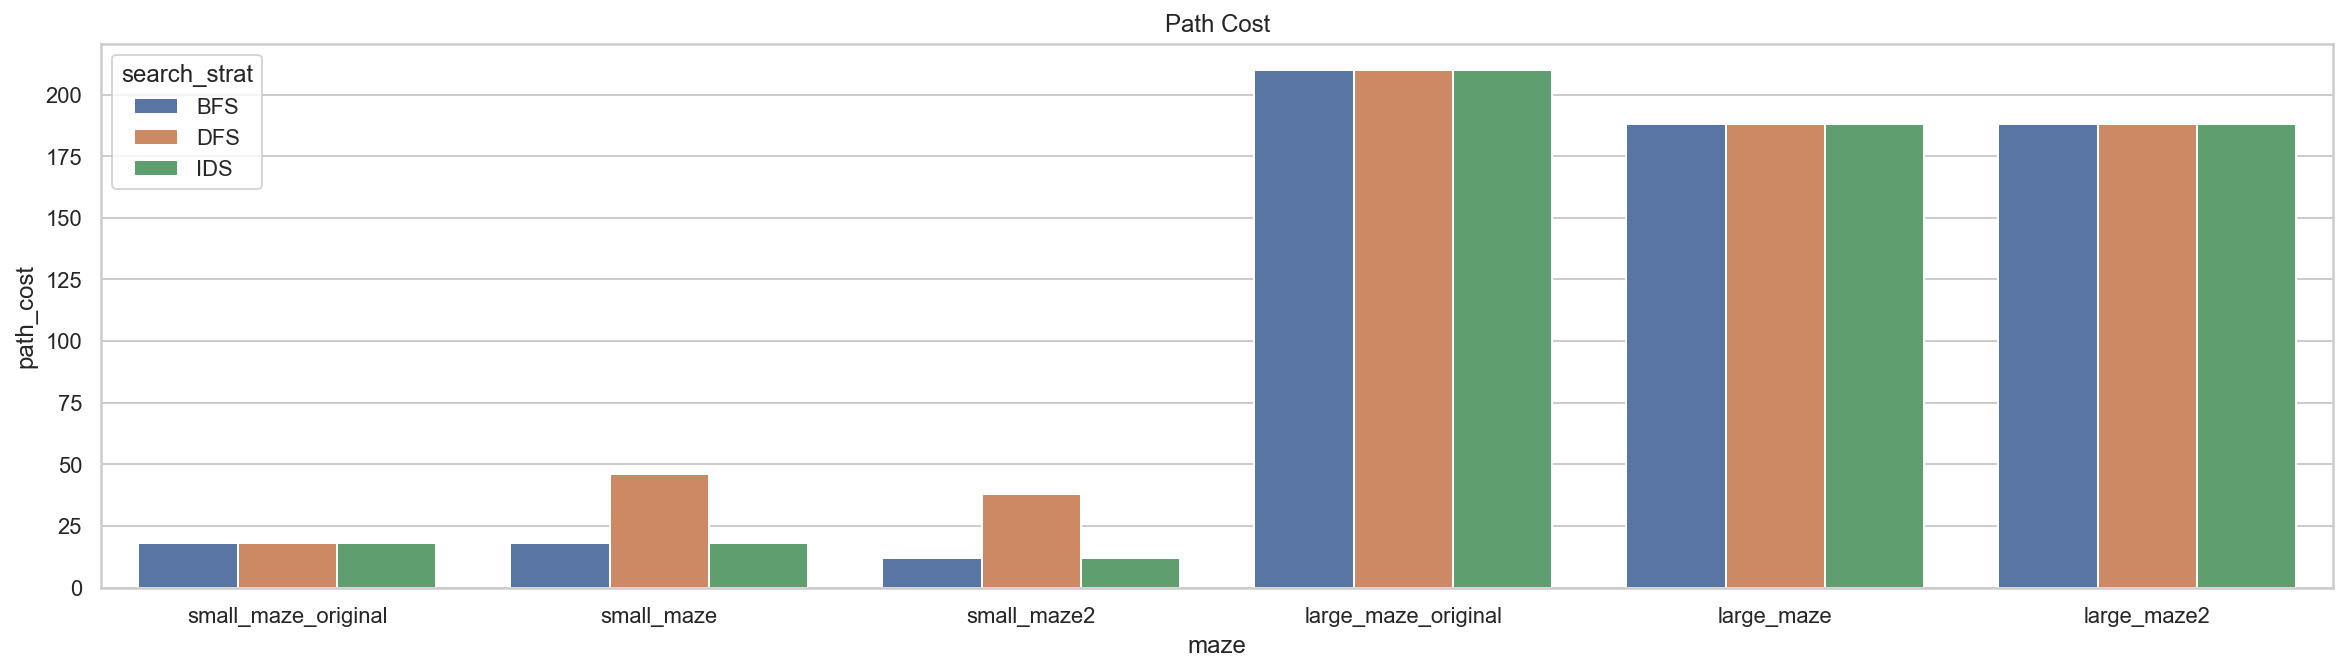

In [26]:
import seaborn as sns
plt.figure(figsize=(20,5))

sns.set_theme(style="whitegrid")
ax = sns.barplot(x="maze", y="path_cost", data=df, hue='search_strat')
ax.title.set_text('Path Cost')

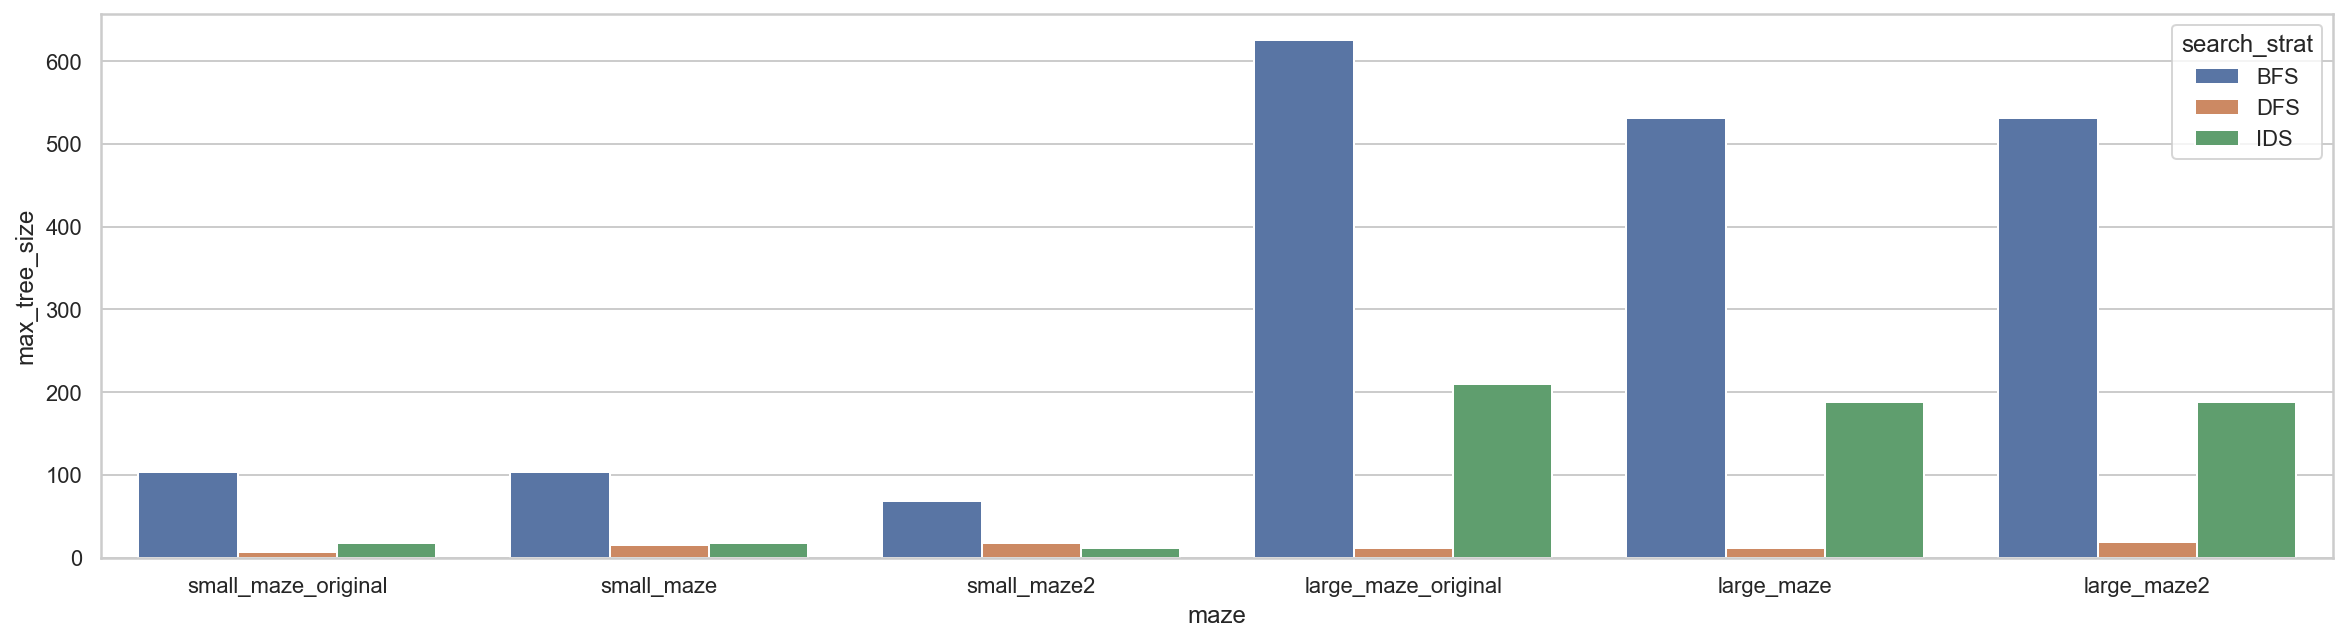

In [27]:
plt.figure(figsize=(20,5))
sns.set_theme(style="whitegrid")
ax2 = sns.barplot(x="maze", y="max_tree_size", data=df, hue='search_strat')
ax.title.set_text('Max Tree Size')

## More advanced tasks to think about

#### Instead of defining each square as a state (which you probably did), use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length in number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

To keep BFS and IDS optimal, all you'd have to do is once you find a solution, you extedn all other branches to nodes that are greater than the found solution.  This way you knwo you can't find a better solution, because you already know no matter how much deep you go in the tree it won't beat what you alread found.

#### Modify your A* search to add weights (see text book) and explore how different weights influence the result.

I wasn't able to write the code to achieve this, but this is what I think would happen.  The A* search would be less likely to be tricked.  There are many paths that it would be able to use the destination to add to the hueristic.  That could keep it from searching through a U-turn that will not lead to results.

#### What happens if the agent does not know the layout of the maze in advance (i.e., faces an unkown, only partially observable environment)? How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

#### Performance
This is the same as the above mazes.  The number of steps the solution has, and the speed the algorithm took to get to that solution.
#### Environment
The parts of the maze that the agent can and cannot obeserve.
#### Actuators
Theg methods the algorithm uses to actually move through the maze.
#### Sensors 
Detection if there is a wall

I if were to implement an agent to try and solve this maze I would implement an agent to literally walk through A* search.  It would not be able to use the path cost trick described above since it will have to actually step through the maze to observe the environment.  But this would make its step in a meangingful way whilst not repeating it self too much.